In [1]:
import tensorflow as tf
import os
import time
import numpy as np

def listaArchivos(path):
    """This function gets all the files in a directory"""
    filelist=[]
    with os.scandir(path) as entries:
        for i in entries:
            filelist.append(path+'/'+i.name)
    return filelist

def decode(serialized_example):
    featuress= tf.io.parse_single_example(
    serialized_example,
    features={'noisy': tf.io.FixedLenFeature(shape=(7225,), dtype= tf.float32),#85,85
      'clean':tf.io.FixedLenFeature(shape=(7225,), dtype=tf.float32),
      'NLM':tf.io.FixedLenFeature(shape=(81920,), dtype=tf.float32),#64,64,20
    })
    return featuress

# normal slicing

foldertrain = "./../DatasetBueno/cleanpart_1/train"# ./cleanpart_1/train
foldertest = "./../DatasetBueno/cleanpart_1/test"# ./cleanpart_1/test
#start = time.perf_counter()
#randomize the files
randtrainlist=np.array(listaArchivos(foldertrain))
np.random.shuffle(randtrainlist)
randtrainlist=list(randtrainlist)
randtestlist=np.array(listaArchivos(foldertest))
np.random.shuffle(randtestlist)
randtrainlist=list(randtestlist)
# data geneerator
ds_train = tf.data.TFRecordDataset(randtrainlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
ds_test = tf.data.TFRecordDataset(randtestlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
#print(time.perf_counter()-start)
# Disable the order so its faster to run
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
ds_train = ds_train.with_options(ignore_order)
ds_test = ds_test.with_options(ignore_order)# uses data as soon as it streams in, rather than in its original order
# try the simple function of slicing
#print(time.perf_counter()-start)# 31 segundos en cortar 12 gigas, aunque no las carga del todo. solo si las traigo a colación las carga
# Slicing normal didnt seemn to work well.

In [2]:
def sliceN2(data):
    data = tf.reshape(data, [85,85], name="noisy")
    data=tf.convert_to_tensor(data[11:75,11:75])
    data=tf.reshape(data,[64,64,1],name='noisy')
    return data
def sliceC(data):
    data = tf.reshape(data, [85,85], name="clean")
    data=tf.convert_to_tensor(data[11:75,11:75])
    return data
def sliceNLM(data):
    data = tf.reshape(data, [64,64,20], name="NLM")
    return data
#[image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#image.set_shape(im_shape)
def tf_slicing2(elem):
    clean=elem['clean']
    noisy=elem['noisy']
    NLM=elem['NLM']
    
    [clean,] = tf.py_function(sliceC,[clean], [tf.float32])#[clean,] =
    [noisy,] = tf.py_function(sliceN2,[noisy], [tf.float32])
    [NLM,] = tf.py_function(sliceNLM,[NLM], [tf.float32])
    noisy = tf.concat(axis=2, values=[noisy,NLM,])# concatenating the NLM with the noisy to get only one x
    noisy = tf.cast(noisy, tf.float64)# Converting to float64 to save longer values maybe
    clean = tf.cast(clean, tf.float64)# Converting to float64 to save longer values maybe
    #clip the bad data
    noisy = tf.clip_by_value(noisy, clip_value_min=0, clip_value_max=1, name='noisy')# Eliminate some weird infinities
    clean = tf.clip_by_value(clean, clip_value_min=0, clip_value_max=1, name='clean')# Eliminate some weird infinities
    
    
    return  noisy,clean

pros_ds_train = ds_train.map(tf_slicing2)
pros_ds_test = ds_test.map(tf_slicing2)

In [3]:
# New model
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np



input_size=(64,64,21)#batch_size,
inputs = keras.Input(shape=(*input_size,), name="noisy", dtype=tf.float32)#With this, the batch_size can varylayers.Input(shape=(64, 64, 21)),
l1 = layers.Conv2D(1, (3, 3), activation='ReLU', padding='same')(inputs)
B1 = layers.BatchNormalization()(l1)
l2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B1)
B2 = layers.BatchNormalization()(l2)
l3 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B2)
B3 = layers.BatchNormalization()(l3)
l4 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B3)
B4 = layers.BatchNormalization()(l4)
l5 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B4)
B5 = layers.BatchNormalization()(l5)
l6 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B5)
B6 = layers.BatchNormalization()(l6)
l7 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B6)
B7 = layers.BatchNormalization()(l7)
l8 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B7)
B8 = layers.BatchNormalization()(l8)
l9 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B8)
B9 = layers.BatchNormalization()(l9)
l10 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B9)
B10 = layers.BatchNormalization()(l10)
l11 = layers.Conv2D(21, (3, 3), strides=2, activation='LeakyReLU')(B10)
B11 = layers.BatchNormalization()(l11)
outres = layers.Add()([inputs,B11])
l12 = layers.Conv2D(1, (3, 3), activation='LeakyReLU', padding='same')(outres)
outputs = layers.BatchNormalization()(l12)
modelF = keras.Model(inputs=inputs, outputs=outputs)
modelF.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noisy (InputLayer)             [(None, 64, 64, 21)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 1)    190         ['noisy[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 1)   4           ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [4]:
# custom loss function
import keras.backend as K
import sklearn

class CustomAccuracySAR2(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        #y_true=y_true[0]
        y_true,y_pred=tf.math.multiply(y_true,np.log(256)),tf.math.multiply(y_pred,np.log(256))# first denormalize
        y_true,y_pred=tf.math.add(tf.math.exp(y_true),-1),tf.math.add(tf.math.exp(y_pred),-1)# then add subtract the slide
        # Clipping
        y_true= tf.clip_by_value(y_true, 0, 255)
        y_pred= tf.clip_by_value(y_pred, 0, 255)
        denom = tf.math.sqrt(tf.math.multiply(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01)))# the 0.02 is to avoid the problem with the logarithm
        SARdist= tf.math.log(tf.math.divide(tf.math.add(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01))+0.001,denom + 0.001))
        return SARdist
    
def custom_loss(y_true, y_pred):
    l_1 = 0.7
    l_2 = 0.3
    mse = tf.keras.losses.MeanSquaredError()
    SARdist = CustomAccuracySAR2()
    loss_Sard = SARdist(y_true , y_pred)
    loss_mse = mse(y_true , y_pred)
    total_loss = l_1*loss_mse + l_2*loss_Sard.numpy()
    return total_loss

In [5]:
### This one worksss
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import time

#Memory configuration
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.inter_op_parallelism_threads = 8
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session((tf.compat.v1.Session(config=config)))


# general parameters and 
Epochs = 10
batch_size=128
AUTOTUNE = tf.data.AUTOTUNE
pros_ds_train = pros_ds_train.batch(batch_size = batch_size , drop_remainder=True)
pros_ds_test = pros_ds_test.batch(batch_size = batch_size , drop_remainder=True)
pros_ds_train = pros_ds_train.prefetch(buffer_size=AUTOTUNE)
pros_ds_test = pros_ds_test.prefetch(buffer_size=AUTOTUNE)


modelF2 = keras.Model(inputs=inputs, outputs=outputs)
#modelF2.summary()
modelF2.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), loss=custom_loss, metrics=[tf.keras.metrics.MeanSquaredError()], run_eagerly=True)

First_time = time.time()
callbacks = [
    keras.callbacks.EarlyStopping(# This is for early stopping and convergence
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-1,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
train_loss_results = []
train_accuracy_results = []
iterator = iter(pros_ds_train)
iter2 = iter(pros_ds_test)
# If this doesn't worlk make epochs more and erase the for epochs
for j in range(Epochs):
    history = modelF2.fit(iterator,
                    epochs=1,
                    callbacks=callbacks,
                    validation_data=iter2,#pros_ds_test
                    batch_size=batch_size)#batch_size=batch_size)#batch_size=batch_size
    iterator = iter(pros_ds_train)
    iter2 = iter(pros_ds_test)
    print(j)
    modelF2.save('CNNLM1Iter')
    train_loss_results.append(history.history["loss"])
    train_accuracy_results.append(history.history["val_loss"])
print("Total tim: %.2fs" % (time.time() - First_time))
#new_model = keras.models.load_model('path_to_my_model.h5')


277/277 [==============================] - 4972s 18s/step - loss: 1.4393 - mean_squared_error: 1.0402 - val_loss: 0.3949 - val_mean_squared_error: 0.0978
0


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


277/277 [==============================] - 4892s 18s/step - loss: 0.8833 - mean_squared_error: 0.4766 - val_loss: 0.6324 - val_mean_squared_error: 0.2224
1


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


277/277 [==============================] - 4992s 18s/step - loss: 0.5201 - mean_squared_error: 0.1873 - val_loss: 0.3097 - val_mean_squared_error: 0.0640
2


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


277/277 [==============================] - 5003s 18s/step - loss: 0.3205 - mean_squared_error: 0.0615 - val_loss: 0.2460 - val_mean_squared_error: 0.0222
3


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


277/277 [==============================] - 4808s 17s/step - loss: 0.2387 - mean_squared_error: 0.0165 - val_loss: 0.2191 - val_mean_squared_error: 0.0060
4


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


277/277 [==============================] - 4807s 17s/step - loss: 0.2152 - mean_squared_error: 0.0038 - val_loss: 0.2108 - val_mean_squared_error: 0.0014
5


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


277/277 [==============================] - 4807s 17s/step - loss: 0.2102 - mean_squared_error: 9.9512e-04 - val_loss: 0.2095 - val_mean_squared_error: 5.2380e-04
6


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


277/277 [==============================] - 4851s 18s/step - loss: 0.2096 - mean_squared_error: 5.4081e-04 - val_loss: 0.2095 - val_mean_squared_error: 4.0363e-04
7


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


277/277 [==============================] - 4822s 17s/step - loss: 0.2097 - mean_squared_error: 4.7645e-04 - val_loss: 0.2095 - val_mean_squared_error: 3.8384e-04
8


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


277/277 [==============================] - 4832s 17s/step - loss: 0.2097 - mean_squared_error: 4.6371e-04 - val_loss: 0.2093 - val_mean_squared_error: 3.7262e-04
9


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


INFO:tensorflow:Assets written to: CNNLM1Iter\assets


Total tim: 48829.21s


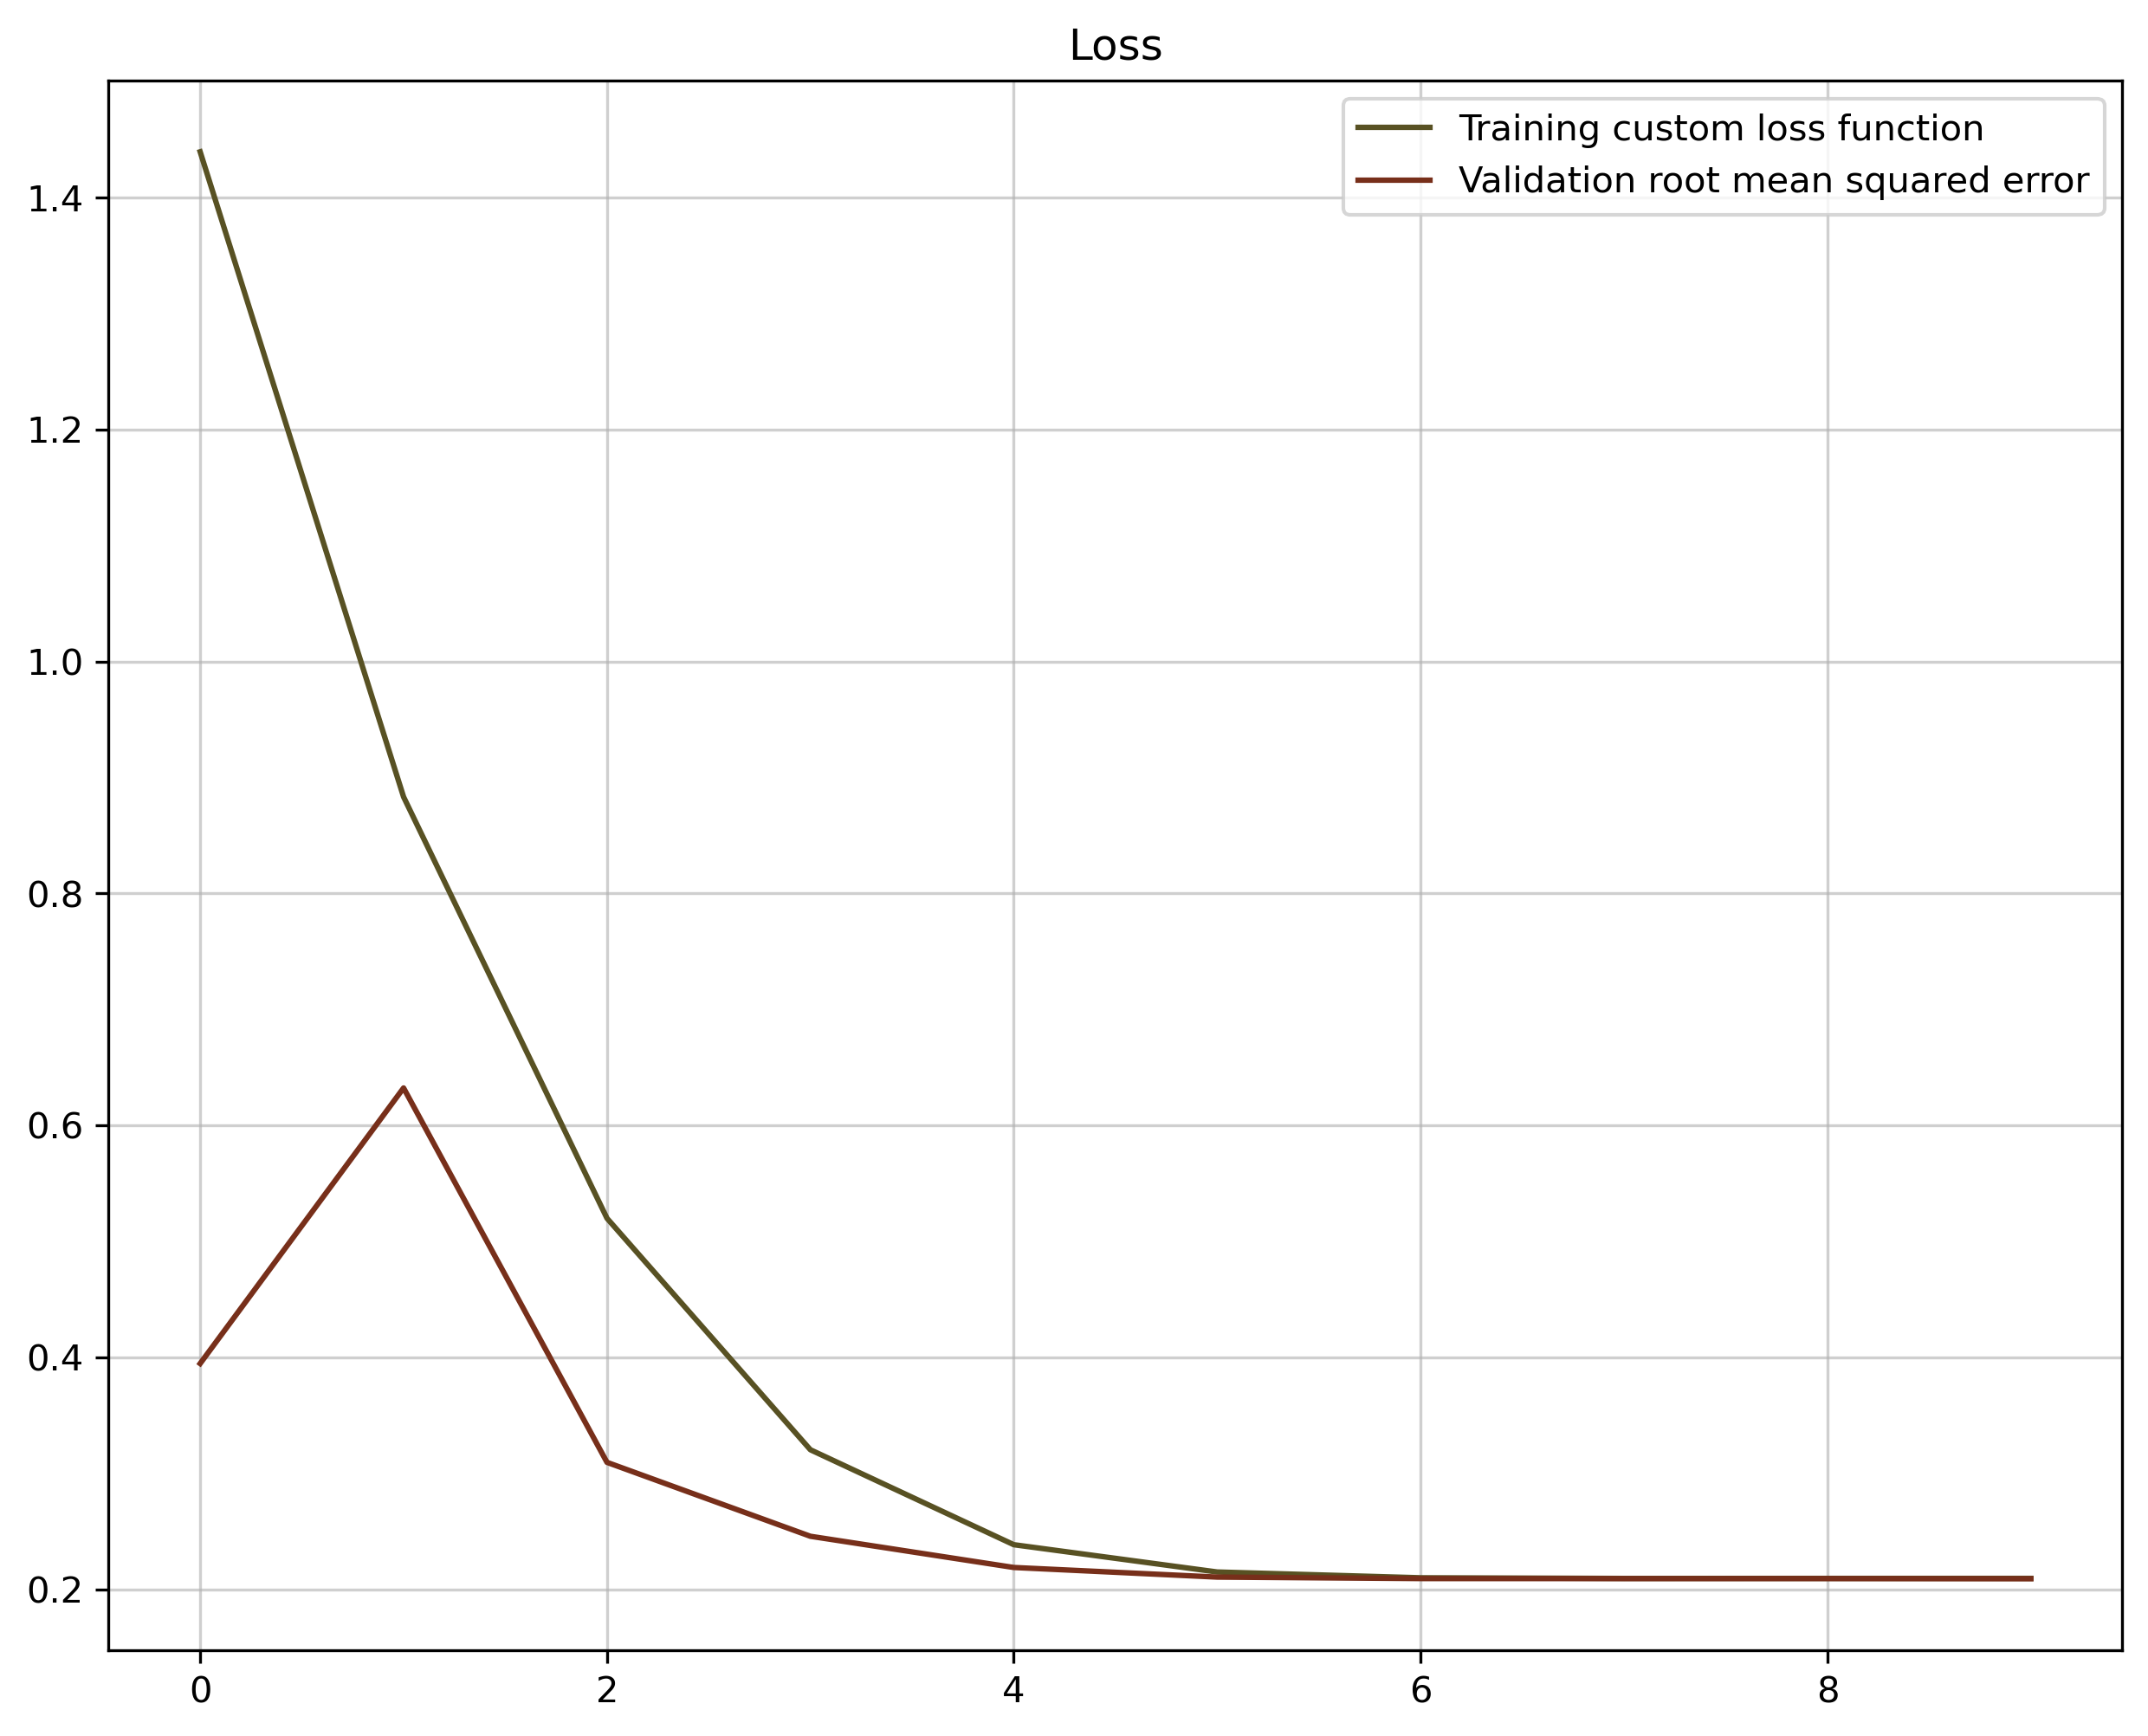

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=300)
plt.plot(train_loss_results, label="Training custom loss function",color="#585123")
plt.plot(train_accuracy_results, label="Validation root mean squared error",color="#772F1A")
plt.grid(alpha=0.6)
plt.title('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 141ms/step


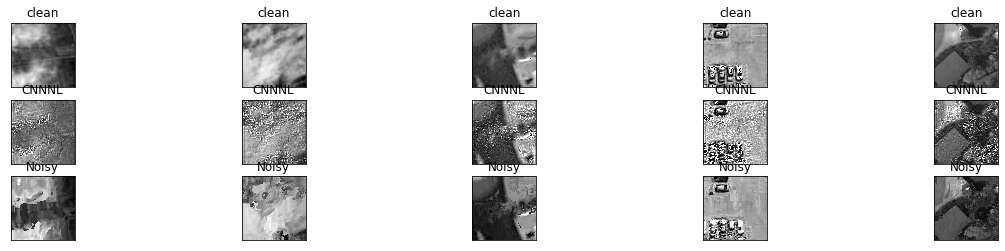

In [31]:
# Visualization
pros_ds_test = ds_test.map(tf_slicing2)
for batch_x, batch_y in pros_ds_test.batch(5).take(10):
    decoded_imgs = modelF2.predict(batch_x)
decoded_imgs= tf.clip_by_value(decoded_imgs, 0,1)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgs,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide

#The noisy image
trainD=tf.math.multiply(batch_x,np.log(256))
trainD=tf.math.add(tf.math.exp(trainD),-1)
trainD=trainD[:,:,:,1]

decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)
trainD= tf.clip_by_value(trainD, 0, 255)
import matplotlib.pyplot as plt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("clean")
    plt.imshow(tf.squeeze(test_y[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("CNNNL")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    cx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Noisy")
    plt.imshow(tf.squeeze(trainD[i]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)
plt.show()

# Cross validation 2

In [1]:
import tensorflow as tf
import os
import time
import numpy as np

def listaArchivos(path):
    """This function gets all the files in a directory"""
    filelist=[]
    with os.scandir(path) as entries:
        for i in entries:
            filelist.append(path+'/'+i.name)
    return filelist

def decode(serialized_example):
    featuress= tf.io.parse_single_example(
    serialized_example,
    features={'noisy': tf.io.FixedLenFeature(shape=(7225,), dtype= tf.float32),#85,85
      'clean':tf.io.FixedLenFeature(shape=(7225,), dtype=tf.float32),
      'NLM':tf.io.FixedLenFeature(shape=(81920,), dtype=tf.float32),#64,64,20
    })
    return featuress

# normal slicing

foldertrain = "./../DatasetBueno/cleanpart_2/train"# ./cleanpart_1/train
foldertest = "./../DatasetBueno/cleanpart_2/test"# ./cleanpart_1/test
#start = time.perf_counter()
#randomize the files
randtrainlist=np.array(listaArchivos(foldertrain))
np.random.shuffle(randtrainlist)
randtrainlist=list(randtrainlist)
randtestlist=np.array(listaArchivos(foldertest))
np.random.shuffle(randtestlist)
randtrainlist=list(randtestlist)
# data geneerator
ds_train = tf.data.TFRecordDataset(randtrainlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
ds_test = tf.data.TFRecordDataset(randtestlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
#print(time.perf_counter()-start)
# Disable the order so its faster to run
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
ds_train = ds_train.with_options(ignore_order)
ds_test = ds_test.with_options(ignore_order)# uses data as soon as it streams in, rather than in its original order
# try the simple function of slicing
#print(time.perf_counter()-start)# 31 segundos en cortar 12 gigas, aunque no las carga del todo. solo si las traigo a colación las carga
# Slicing normal didnt seemn to work well.

In [2]:
def sliceN2(data):
    data = tf.reshape(data, [85,85], name="noisy")
    data=tf.convert_to_tensor(data[11:75,11:75])
    data=tf.reshape(data,[64,64,1],name='noisy')
    return data
def sliceC(data):
    data = tf.reshape(data, [85,85], name="clean")
    data=tf.convert_to_tensor(data[11:75,11:75])
    return data
def sliceNLM(data):
    data = tf.reshape(data, [64,64,20], name="NLM")
    return data
#[image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#image.set_shape(im_shape)
def tf_slicing2(elem):
    clean=elem['clean']
    noisy=elem['noisy']
    NLM=elem['NLM']
    
    [clean,] = tf.py_function(sliceC,[clean], [tf.float32])#[clean,] =
    [noisy,] = tf.py_function(sliceN2,[noisy], [tf.float32])
    [NLM,] = tf.py_function(sliceNLM,[NLM], [tf.float32])
    noisy = tf.concat(axis=2, values=[noisy,NLM,])# concatenating the NLM with the noisy to get only one x
    noisy = tf.cast(noisy, tf.float64)# Converting to float64 to save longer values maybe
    clean = tf.cast(clean, tf.float64)# Converting to float64 to save longer values maybe
    #clip the bad data
    noisy = tf.clip_by_value(noisy, clip_value_min=0, clip_value_max=1, name='noisy')# Eliminate some weird infinities
    clean = tf.clip_by_value(clean, clip_value_min=0, clip_value_max=1, name='clean')# Eliminate some weird infinities
    
    
    return  noisy,clean

pros_ds_train = ds_train.map(tf_slicing2)
pros_ds_test = ds_test.map(tf_slicing2)

In [3]:
# New model
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np



input_size=(64,64,21)#batch_size,
inputs = keras.Input(shape=(*input_size,), name="noisy", dtype=tf.float32)#With this, the batch_size can varylayers.Input(shape=(64, 64, 21)),
l1 = layers.Conv2D(1, (3, 3), activation='ReLU', padding='same')(inputs)
B1 = layers.BatchNormalization()(l1)
l2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B1)
B2 = layers.BatchNormalization()(l2)
l3 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B2)
B3 = layers.BatchNormalization()(l3)
l4 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B3)
B4 = layers.BatchNormalization()(l4)
l5 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B4)
B5 = layers.BatchNormalization()(l5)
l6 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B5)
B6 = layers.BatchNormalization()(l6)
l7 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B6)
B7 = layers.BatchNormalization()(l7)
l8 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B7)
B8 = layers.BatchNormalization()(l8)
l9 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B8)
B9 = layers.BatchNormalization()(l9)
l10 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B9)
B10 = layers.BatchNormalization()(l10)
l11 = layers.Conv2D(21, (3, 3), strides=2, activation='LeakyReLU')(B10)
B11 = layers.BatchNormalization()(l11)
outres = layers.Add()([inputs,B11])
l12 = layers.Conv2D(1, (3, 3), activation='LeakyReLU', padding='same')(outres)
outputs = layers.BatchNormalization()(l12)
modelF = keras.Model(inputs=inputs, outputs=outputs)
modelF.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noisy (InputLayer)             [(None, 64, 64, 21)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 1)    190         ['noisy[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 1)   4           ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [4]:
# custom loss function
import keras.backend as K
import sklearn

class CustomAccuracySAR2(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        #y_true=y_true[0]
        y_true,y_pred=tf.math.multiply(y_true,np.log(256)),tf.math.multiply(y_pred,np.log(256))# first denormalize
        y_true,y_pred=tf.math.add(tf.math.exp(y_true),-1),tf.math.add(tf.math.exp(y_pred),-1)# then add subtract the slide
        # Clipping
        y_true= tf.clip_by_value(y_true, 0, 255)
        y_pred= tf.clip_by_value(y_pred, 0, 255)
        denom = tf.math.sqrt(tf.math.multiply(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01)))# the 0.02 is to avoid the problem with the logarithm
        SARdist= tf.math.log(tf.math.divide(tf.math.add(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01))+0.001,denom + 0.001))
        return SARdist
    
def custom_loss(y_true, y_pred):
    l_1 = 0.7
    l_2 = 0.3
    mse = tf.keras.losses.MeanSquaredError()
    SARdist = CustomAccuracySAR2()
    loss_Sard = SARdist(y_true , y_pred)
    loss_mse = mse(y_true , y_pred)
    total_loss = l_1*loss_mse + l_2*loss_Sard.numpy()
    return total_loss

In [5]:
### This one worksss
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import time

#Memory configuration
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.inter_op_parallelism_threads = 8
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session((tf.compat.v1.Session(config=config)))


# general parameters and 
Epochs = 10
batch_size=128
AUTOTUNE = tf.data.AUTOTUNE
pros_ds_train = pros_ds_train.batch(batch_size = batch_size , drop_remainder=True)
pros_ds_test = pros_ds_test.batch(batch_size = batch_size , drop_remainder=True)
pros_ds_train = pros_ds_train.prefetch(buffer_size=AUTOTUNE)
pros_ds_test = pros_ds_test.prefetch(buffer_size=AUTOTUNE)


modelF3 = keras.Model(inputs=inputs, outputs=outputs)
#modelF2.summary()
modelF3.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), loss=custom_loss, metrics=[tf.keras.metrics.MeanSquaredError()], run_eagerly=True)

First_time = time.time()
callbacks = [
    keras.callbacks.EarlyStopping(# This is for early stopping and convergence
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-1,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
train_loss_results = []
train_accuracy_results = []
iterator = iter(pros_ds_train)
iter2 = iter(pros_ds_test)
# If this doesn't worlk make epochs more and erase the for epochs
for j in range(Epochs):
    history = modelF3.fit(iterator,
                    epochs=1,
                    callbacks=callbacks,
                    validation_data=iter2,#pros_ds_test
                    batch_size=batch_size)#batch_size=batch_size)#batch_size=batch_size
    iterator = iter(pros_ds_train)
    iter2 = iter(pros_ds_test)
    print(j)
    modelF3.save('CNNLM2Iter')
    train_loss_results.append(history.history["loss"])
    train_accuracy_results.append(history.history["val_loss"])
print("Total tim: %.2fs" % (time.time() - First_time))
#new_model = keras.models.load_model('path_to_my_model.h5')


276/276 [==============================] - 4784s 17s/step - loss: 1.4487 - mean_squared_error: 1.0468 - val_loss: 0.7174 - val_mean_squared_error: 0.2742
0


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


276/276 [==============================] - 4752s 17s/step - loss: 0.8891 - mean_squared_error: 0.4810 - val_loss: 0.8486 - val_mean_squared_error: 0.3380
1


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


276/276 [==============================] - 4754s 17s/step - loss: 0.5218 - mean_squared_error: 0.1897 - val_loss: 0.3008 - val_mean_squared_error: 0.0493
2


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


276/276 [==============================] - 4742s 17s/step - loss: 0.3216 - mean_squared_error: 0.0624 - val_loss: 0.4862 - val_mean_squared_error: 0.1489
3


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


276/276 [==============================] - 4749s 17s/step - loss: 0.2412 - mean_squared_error: 0.0175 - val_loss: 0.2528 - val_mean_squared_error: 0.0239
4


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


276/276 [==============================] - 4751s 17s/step - loss: 0.2165 - mean_squared_error: 0.0044 - val_loss: 0.2216 - val_mean_squared_error: 0.0087
5


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


276/276 [==============================] - 4744s 17s/step - loss: 0.2107 - mean_squared_error: 0.0013 - val_loss: 0.2159 - val_mean_squared_error: 0.0045
6


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


276/276 [==============================] - 4747s 17s/step - loss: 0.2096 - mean_squared_error: 5.5051e-04 - val_loss: 0.2118 - val_mean_squared_error: 0.0018
7


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


276/276 [==============================] - 4751s 17s/step - loss: 0.2096 - mean_squared_error: 4.4786e-04 - val_loss: 0.2104 - val_mean_squared_error: 0.0010
8


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


276/276 [==============================] - 4751s 17s/step - loss: 0.2095 - mean_squared_error: 3.7490e-04 - val_loss: 0.2098 - val_mean_squared_error: 7.2445e-04
9


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


INFO:tensorflow:Assets written to: CNNLM2Iter\assets


Total tim: 47571.01s


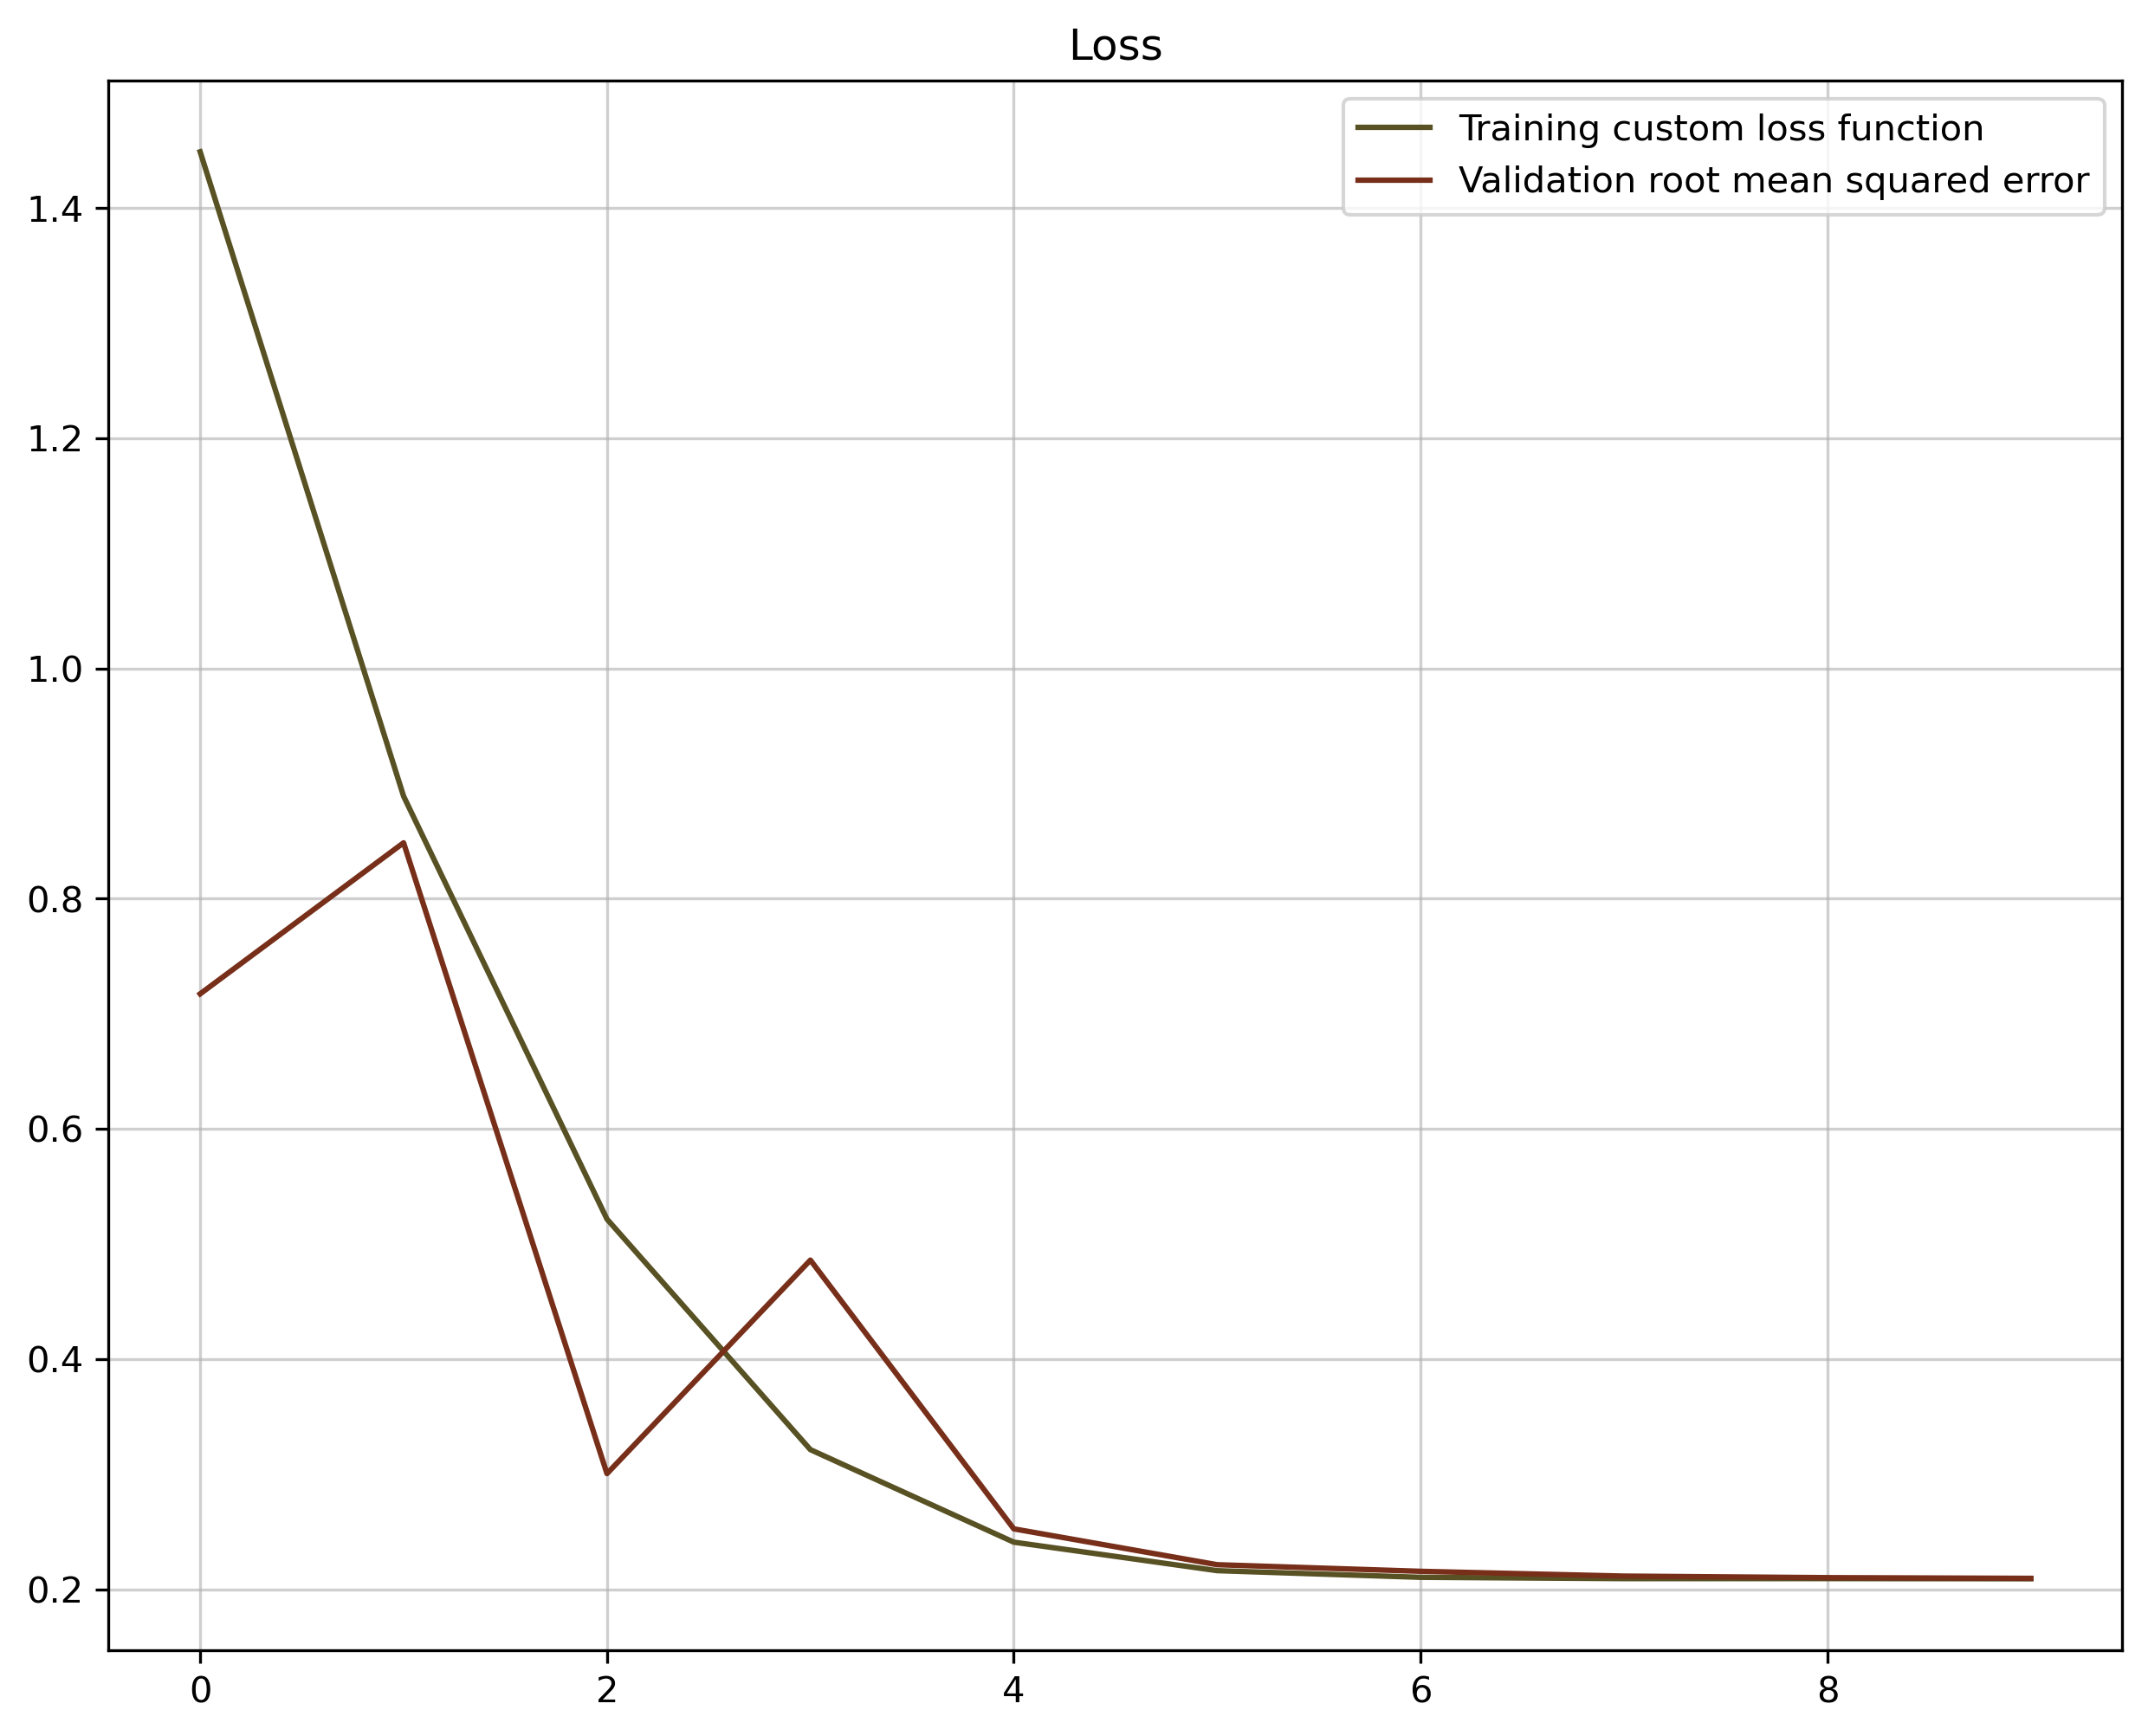

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=300)
plt.plot(train_loss_results, label="Training custom loss function",color="#585123")
plt.plot(train_accuracy_results, label="Validation root mean squared error",color="#772F1A")
plt.grid(alpha=0.6)
plt.title('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 196ms/step


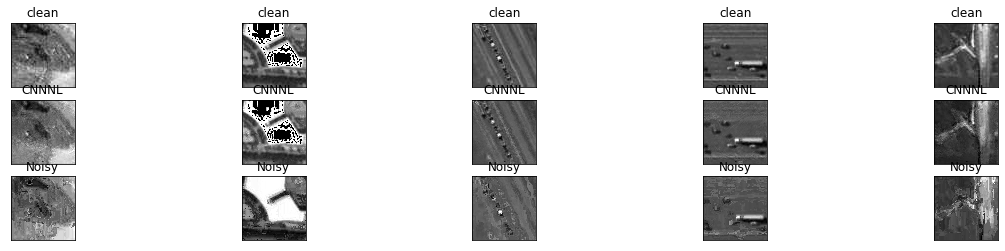

In [7]:

# Visualization
pros_ds_test = ds_test.map(tf_slicing2)
for batch_x, batch_y in pros_ds_test.batch(5).take(10):
    decoded_imgs = modelF3.predict(batch_x)
    
decoded_imgs= tf.clip_by_value(decoded_imgs, 0,1)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgs,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide

#The noisy image
trainD=tf.math.multiply(batch_x,np.log(256))
trainD=tf.math.add(tf.math.exp(trainD),-1)
trainD=trainD[:,:,:,1]

decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)
trainD= tf.clip_by_value(trainD, 0, 255)
import matplotlib.pyplot as plt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("clean")
    plt.imshow(tf.squeeze(test_y[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("CNNNL")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    cx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Noisy")
    plt.imshow(tf.squeeze(trainD[i]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)
plt.show()

# Cross validation 2

In [8]:
import tensorflow as tf
import os
import time
import numpy as np

def listaArchivos(path):
    """This function gets all the files in a directory"""
    filelist=[]
    with os.scandir(path) as entries:
        for i in entries:
            filelist.append(path+'/'+i.name)
    return filelist

def decode(serialized_example):
    featuress= tf.io.parse_single_example(
    serialized_example,
    features={'noisy': tf.io.FixedLenFeature(shape=(7225,), dtype= tf.float32),#85,85
      'clean':tf.io.FixedLenFeature(shape=(7225,), dtype=tf.float32),
      'NLM':tf.io.FixedLenFeature(shape=(81920,), dtype=tf.float32),#64,64,20
    })
    return featuress

# normal slicing

foldertrain = "./../DatasetBueno/cleanpart_3/train"# ./cleanpart_1/train
foldertest = "./../DatasetBueno/cleanpart_3/test"# ./cleanpart_1/test
#start = time.perf_counter()
#randomize the files
randtrainlist=np.array(listaArchivos(foldertrain))
np.random.shuffle(randtrainlist)
randtrainlist=list(randtrainlist)
randtestlist=np.array(listaArchivos(foldertest))
np.random.shuffle(randtestlist)
randtrainlist=list(randtestlist)
# data geneerator
ds_train = tf.data.TFRecordDataset(randtrainlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
ds_test = tf.data.TFRecordDataset(randtestlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
#print(time.perf_counter()-start)
# Disable the order so its faster to run
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
ds_train = ds_train.with_options(ignore_order)
ds_test = ds_test.with_options(ignore_order)# uses data as soon as it streams in, rather than in its original order
# try the simple function of slicing
#print(time.perf_counter()-start)# 31 segundos en cortar 12 gigas, aunque no las carga del todo. solo si las traigo a colación las carga
# Slicing normal didnt seemn to work well.

In [9]:
def sliceN2(data):
    data = tf.reshape(data, [85,85], name="noisy")
    data=tf.convert_to_tensor(data[11:75,11:75])
    data=tf.reshape(data,[64,64,1],name='noisy')
    return data
def sliceC(data):
    data = tf.reshape(data, [85,85], name="clean")
    data=tf.convert_to_tensor(data[11:75,11:75])
    return data
def sliceNLM(data):
    data = tf.reshape(data, [64,64,20], name="NLM")
    return data
#[image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#image.set_shape(im_shape)
def tf_slicing2(elem):
    clean=elem['clean']
    noisy=elem['noisy']
    NLM=elem['NLM']
    
    [clean,] = tf.py_function(sliceC,[clean], [tf.float32])#[clean,] =
    [noisy,] = tf.py_function(sliceN2,[noisy], [tf.float32])
    [NLM,] = tf.py_function(sliceNLM,[NLM], [tf.float32])
    noisy = tf.concat(axis=2, values=[noisy,NLM,])# concatenating the NLM with the noisy to get only one x
    noisy = tf.cast(noisy, tf.float64)# Converting to float64 to save longer values maybe
    clean = tf.cast(clean, tf.float64)# Converting to float64 to save longer values maybe
    #clip the bad data
    noisy = tf.clip_by_value(noisy, clip_value_min=0, clip_value_max=1, name='noisy')# Eliminate some weird infinities
    clean = tf.clip_by_value(clean, clip_value_min=0, clip_value_max=1, name='clean')# Eliminate some weird infinities
    
    
    return  noisy,clean

pros_ds_train = ds_train.map(tf_slicing2)
pros_ds_test = ds_test.map(tf_slicing2)

In [10]:
# New model
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np



input_size=(64,64,21)#batch_size,
inputs = keras.Input(shape=(*input_size,), name="noisy", dtype=tf.float32)#With this, the batch_size can varylayers.Input(shape=(64, 64, 21)),
l1 = layers.Conv2D(1, (3, 3), activation='ReLU', padding='same')(inputs)
B1 = layers.BatchNormalization()(l1)
l2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B1)
B2 = layers.BatchNormalization()(l2)
l3 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B2)
B3 = layers.BatchNormalization()(l3)
l4 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B3)
B4 = layers.BatchNormalization()(l4)
l5 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B4)
B5 = layers.BatchNormalization()(l5)
l6 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B5)
B6 = layers.BatchNormalization()(l6)
l7 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B6)
B7 = layers.BatchNormalization()(l7)
l8 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B7)
B8 = layers.BatchNormalization()(l8)
l9 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B8)
B9 = layers.BatchNormalization()(l9)
l10 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B9)
B10 = layers.BatchNormalization()(l10)
l11 = layers.Conv2D(21, (3, 3), strides=2, activation='LeakyReLU')(B10)
B11 = layers.BatchNormalization()(l11)
outres = layers.Add()([inputs,B11])
l12 = layers.Conv2D(1, (3, 3), activation='LeakyReLU', padding='same')(outres)
outputs = layers.BatchNormalization()(l12)
modelF = keras.Model(inputs=inputs, outputs=outputs)
modelF.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noisy (InputLayer)             [(None, 64, 64, 21)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 1)    190         ['noisy[0][0]']                  
                                                                                                  
 batch_normalization_12 (BatchN  (None, 64, 64, 1)   4           ['conv2d_7[0][0]']               
 ormalization)                                                                                    
                                                                                            

In [11]:
# custom loss function
import keras.backend as K
import sklearn

class CustomAccuracySAR2(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        #y_true=y_true[0]
        y_true,y_pred=tf.math.multiply(y_true,np.log(256)),tf.math.multiply(y_pred,np.log(256))# first denormalize
        y_true,y_pred=tf.math.add(tf.math.exp(y_true),-1),tf.math.add(tf.math.exp(y_pred),-1)# then add subtract the slide
        # Clipping
        y_true= tf.clip_by_value(y_true, 0, 255)
        y_pred= tf.clip_by_value(y_pred, 0, 255)
        denom = tf.math.sqrt(tf.math.multiply(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01)))# the 0.02 is to avoid the problem with the logarithm
        SARdist= tf.math.log(tf.math.divide(tf.math.add(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01))+0.001,denom + 0.001))
        return SARdist
    
def custom_loss(y_true, y_pred):
    l_1 = 0.7
    l_2 = 0.3
    mse = tf.keras.losses.MeanSquaredError()
    SARdist = CustomAccuracySAR2()
    loss_Sard = SARdist(y_true , y_pred)
    loss_mse = mse(y_true , y_pred)
    total_loss = l_1*loss_mse + l_2*loss_Sard.numpy()
    return total_loss

In [12]:
### This one worksss
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import time

#Memory configuration
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.inter_op_parallelism_threads = 8
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session((tf.compat.v1.Session(config=config)))


# general parameters and 
Epochs = 10
batch_size=128
AUTOTUNE = tf.data.AUTOTUNE
pros_ds_train = pros_ds_train.batch(batch_size = batch_size , drop_remainder=True)
pros_ds_test = pros_ds_test.batch(batch_size = batch_size , drop_remainder=True)
pros_ds_train = pros_ds_train.prefetch(buffer_size=AUTOTUNE)
pros_ds_test = pros_ds_test.prefetch(buffer_size=AUTOTUNE)


modelF4 = keras.Model(inputs=inputs, outputs=outputs)
#modelF2.summary()
modelF4.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), loss=custom_loss, metrics=[tf.keras.metrics.MeanSquaredError()], run_eagerly=True)

First_time = time.time()
callbacks = [
    keras.callbacks.EarlyStopping(# This is for early stopping and convergence
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-1,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
train_loss_results = []
train_accuracy_results = []
iterator = iter(pros_ds_train)
iter2 = iter(pros_ds_test)
# If this doesn't worlk make epochs more and erase the for epochs
for j in range(Epochs):
    history = modelF4.fit(iterator,
                    epochs=1,
                    callbacks=callbacks,
                    validation_data=iter2,#pros_ds_test
                    batch_size=batch_size)#batch_size=batch_size)#batch_size=batch_size
    iterator = iter(pros_ds_train)
    iter2 = iter(pros_ds_test)
    print(j)
    modelF4.save('CNNLM3Iter')
    train_loss_results.append(history.history["loss"])
    train_accuracy_results.append(history.history["val_loss"])
print("Total tim: %.2fs" % (time.time() - First_time))
#new_model = keras.models.load_model('path_to_my_model.h5')

279/279 [==============================] - 4837s 17s/step - loss: 1.4270 - mean_squared_error: 1.0263 - val_loss: 7.1364 - val_mean_squared_error: 8.2694
0


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


279/279 [==============================] - 4834s 17s/step - loss: 0.6100 - mean_squared_error: 0.2235 - val_loss: 1.4455 - val_mean_squared_error: 0.6105
1


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


279/279 [==============================] - 4840s 17s/step - loss: 0.3727 - mean_squared_error: 0.0909 - val_loss: 0.3106 - val_mean_squared_error: 0.0567
2


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


279/279 [==============================] - 4845s 17s/step - loss: 0.2758 - mean_squared_error: 0.0375 - val_loss: 0.2417 - val_mean_squared_error: 0.0193
3


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


279/279 [==============================] - 4841s 17s/step - loss: 0.2413 - mean_squared_error: 0.0188 - val_loss: 0.2313 - val_mean_squared_error: 0.0137
4


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


279/279 [==============================] - 4862s 17s/step - loss: 0.2296 - mean_squared_error: 0.0124 - val_loss: 0.2276 - val_mean_squared_error: 0.0114
5


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


279/279 [==============================] - 4860s 17s/step - loss: 0.2245 - mean_squared_error: 0.0095 - val_loss: 0.2236 - val_mean_squared_error: 0.0089
6


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


279/279 [==============================] - 4867s 17s/step - loss: 0.2212 - mean_squared_error: 0.0075 - val_loss: 0.2207 - val_mean_squared_error: 0.0071
7


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


279/279 [==============================] - 4867s 17s/step - loss: 0.2188 - mean_squared_error: 0.0059 - val_loss: 0.2180 - val_mean_squared_error: 0.0055
8


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


279/279 [==============================] - 4920s 18s/step - loss: 0.2168 - mean_squared_error: 0.0048 - val_loss: 0.2161 - val_mean_squared_error: 0.0043
9


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


INFO:tensorflow:Assets written to: CNNLM3Iter\assets


Total tim: 48639.91s


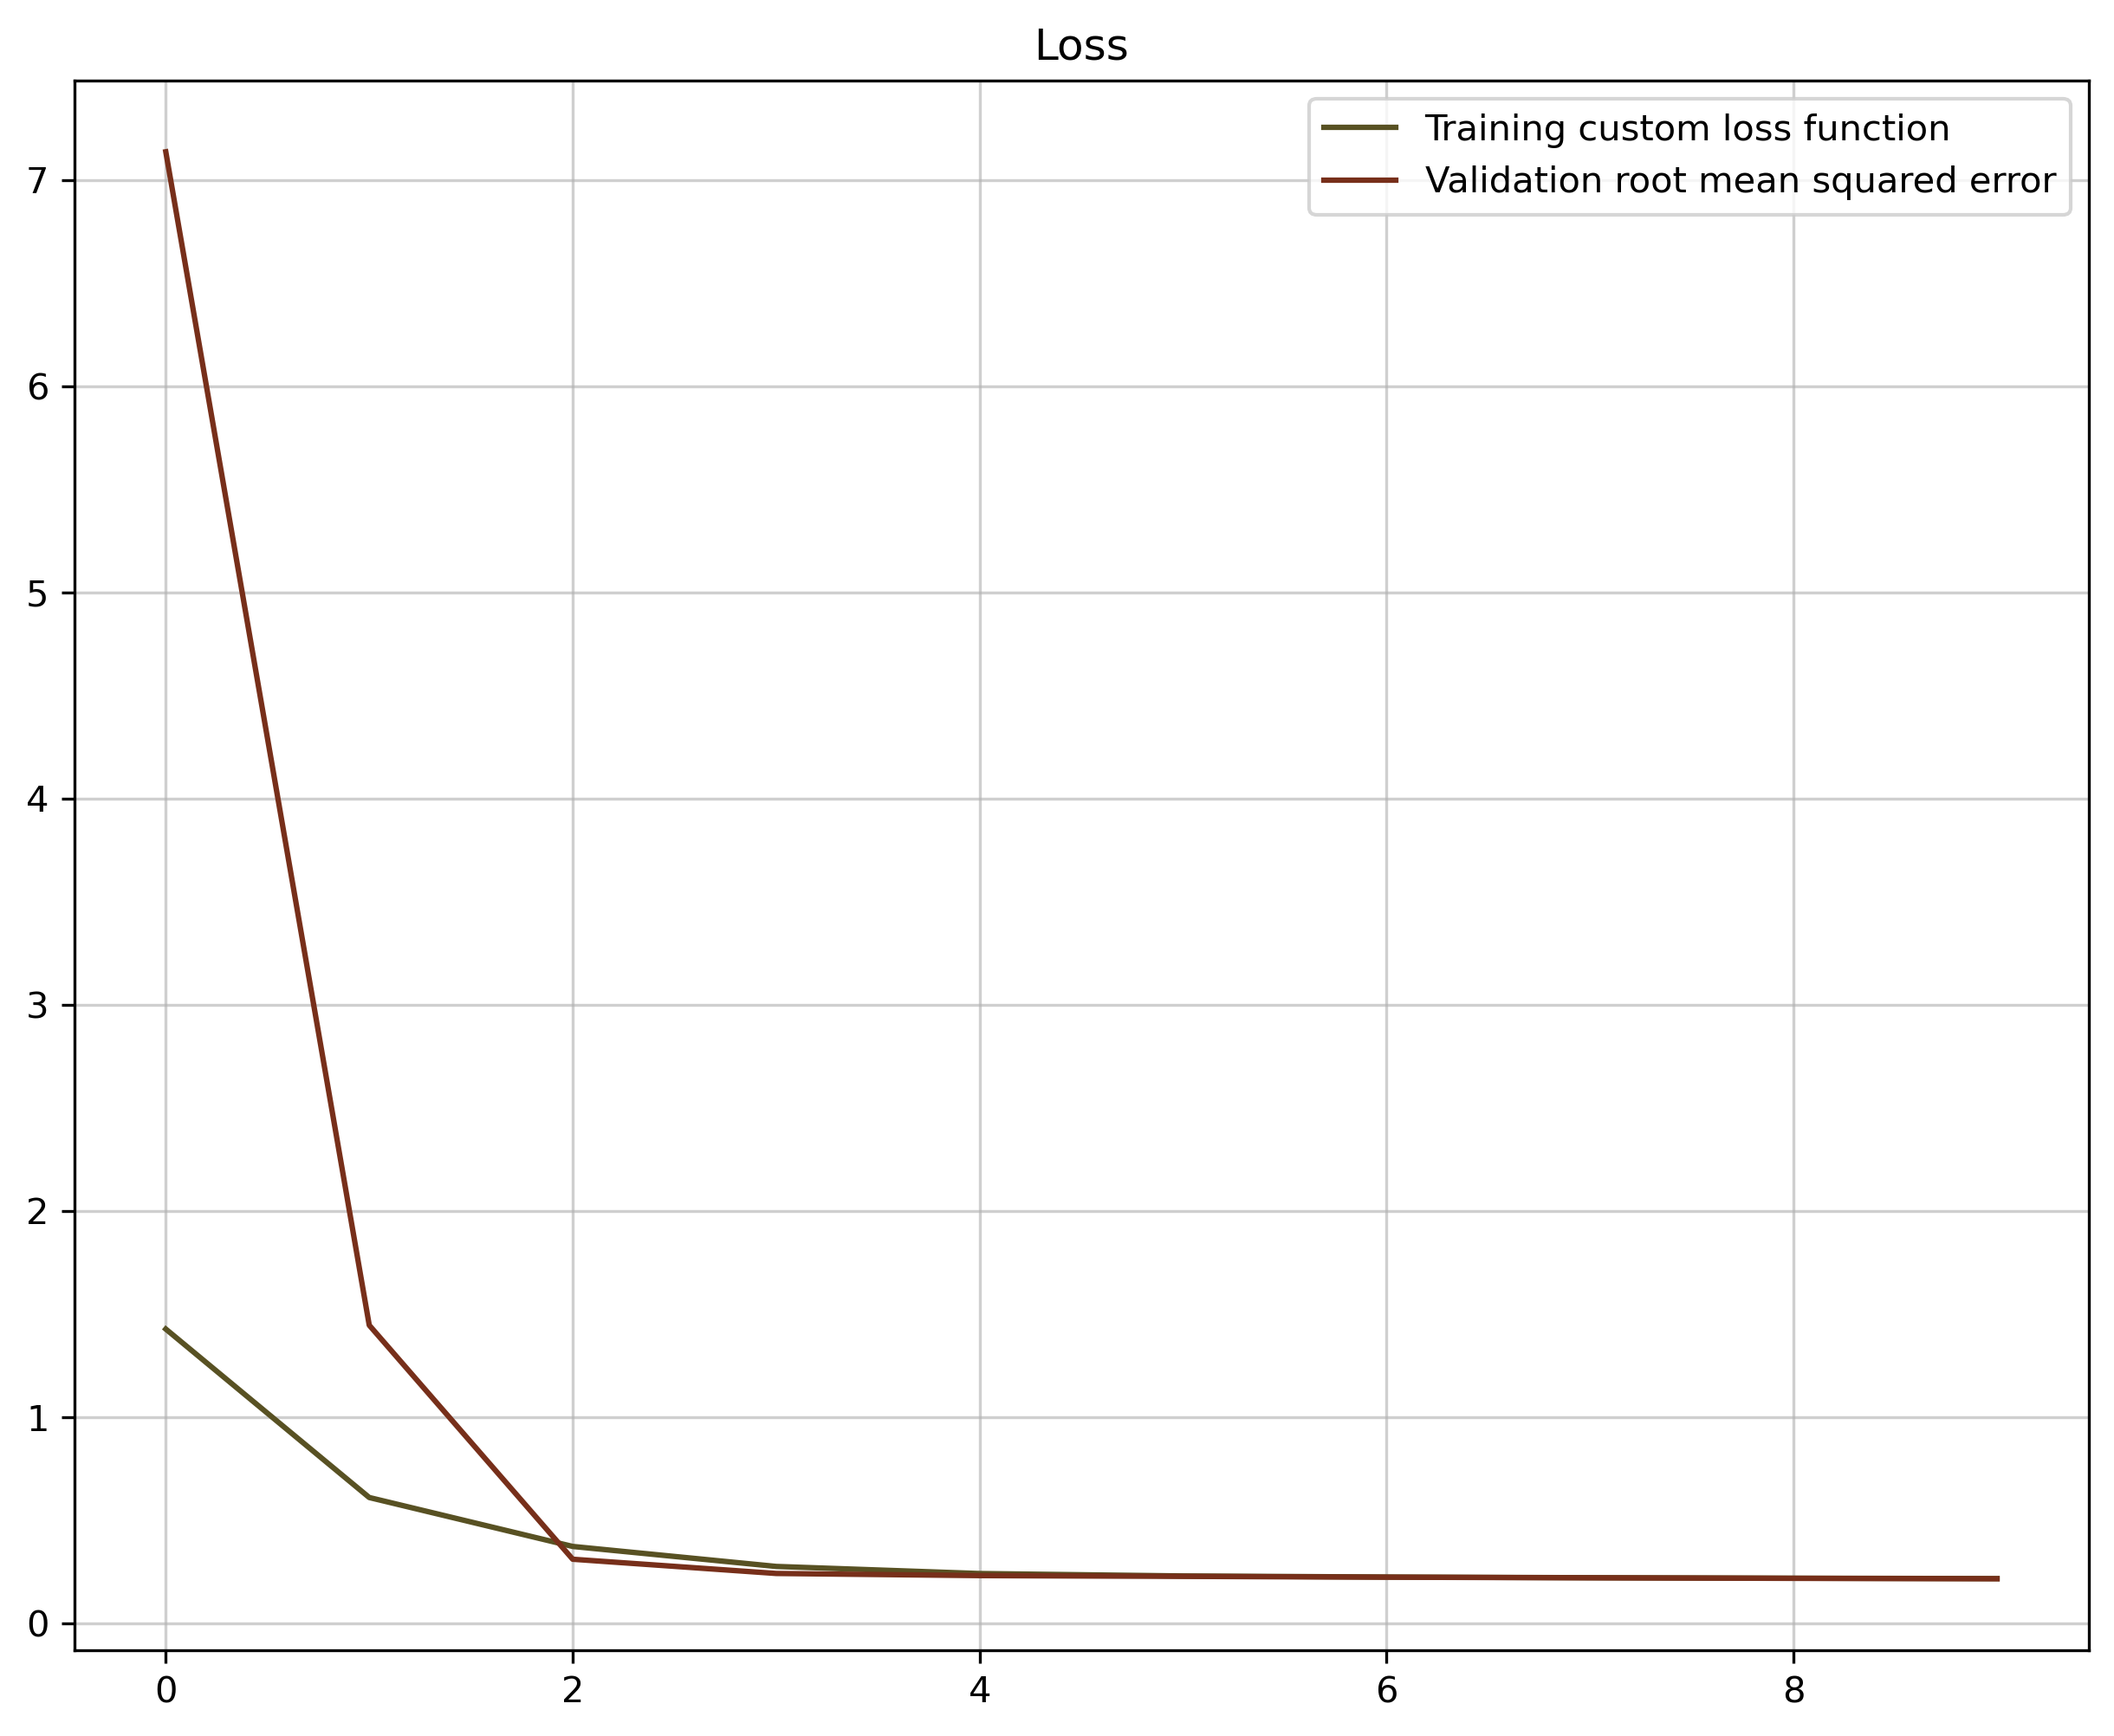

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=300)
plt.plot(train_loss_results, label="Training custom loss function",color="#585123")
plt.plot(train_accuracy_results, label="Validation root mean squared error",color="#772F1A")
plt.grid(alpha=0.6)
plt.title('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 202ms/step


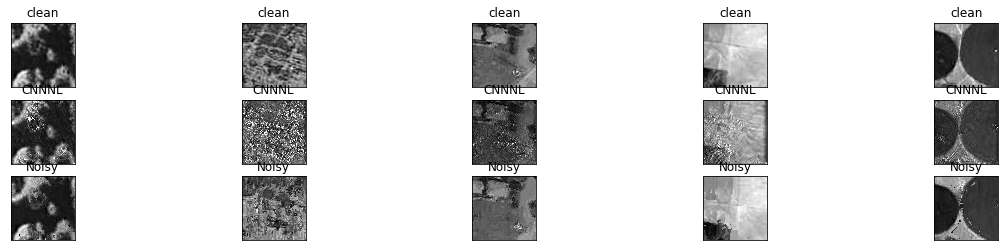

In [14]:
# Visualization
pros_ds_test = ds_test.map(tf_slicing2)
for batch_x, batch_y in pros_ds_test.batch(5).take(10):
    decoded_imgs = modelF4.predict(batch_x)
    
decoded_imgs= tf.clip_by_value(decoded_imgs, 0,1)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgs,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide

#The noisy image
trainD=tf.math.multiply(batch_x,np.log(256))
trainD=tf.math.add(tf.math.exp(trainD),-1)
trainD=trainD[:,:,:,1]

decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)
trainD= tf.clip_by_value(trainD, 0, 255)
import matplotlib.pyplot as plt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("clean")
    plt.imshow(tf.squeeze(test_y[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("CNNNL")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    cx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Noisy")
    plt.imshow(tf.squeeze(trainD[i]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)
plt.show()

# Cross validation 4

In [15]:
import tensorflow as tf
import os
import time
import numpy as np

def listaArchivos(path):
    """This function gets all the files in a directory"""
    filelist=[]
    with os.scandir(path) as entries:
        for i in entries:
            filelist.append(path+'/'+i.name)
    return filelist

def decode(serialized_example):
    featuress= tf.io.parse_single_example(
    serialized_example,
    features={'noisy': tf.io.FixedLenFeature(shape=(7225,), dtype= tf.float32),#85,85
      'clean':tf.io.FixedLenFeature(shape=(7225,), dtype=tf.float32),
      'NLM':tf.io.FixedLenFeature(shape=(81920,), dtype=tf.float32),#64,64,20
    })
    return featuress

# normal slicing

foldertrain = "./../DatasetBueno/cleanpart_4/train"# ./cleanpart_1/train
foldertest = "./../DatasetBueno/cleanpart_4/test"# ./cleanpart_1/test
#start = time.perf_counter()
#randomize the files
randtrainlist=np.array(listaArchivos(foldertrain))
np.random.shuffle(randtrainlist)
randtrainlist=list(randtrainlist)
randtestlist=np.array(listaArchivos(foldertest))
np.random.shuffle(randtestlist)
randtrainlist=list(randtestlist)
# data geneerator
ds_train = tf.data.TFRecordDataset(randtrainlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
ds_test = tf.data.TFRecordDataset(randtestlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
#print(time.perf_counter()-start)
# Disable the order so its faster to run
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
ds_train = ds_train.with_options(ignore_order)
ds_test = ds_test.with_options(ignore_order)# uses data as soon as it streams in, rather than in its original order
# try the simple function of slicing
#print(time.perf_counter()-start)# 31 segundos en cortar 12 gigas, aunque no las carga del todo. solo si las traigo a colación las carga
# Slicing normal didnt seemn to work well.

In [16]:
def sliceN2(data):
    data = tf.reshape(data, [85,85], name="noisy")
    data=tf.convert_to_tensor(data[11:75,11:75])
    data=tf.reshape(data,[64,64,1],name='noisy')
    return data
def sliceC(data):
    data = tf.reshape(data, [85,85], name="clean")
    data=tf.convert_to_tensor(data[11:75,11:75])
    return data
def sliceNLM(data):
    data = tf.reshape(data, [64,64,20], name="NLM")
    return data
#[image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#image.set_shape(im_shape)
def tf_slicing2(elem):
    clean=elem['clean']
    noisy=elem['noisy']
    NLM=elem['NLM']
    
    [clean,] = tf.py_function(sliceC,[clean], [tf.float32])#[clean,] =
    [noisy,] = tf.py_function(sliceN2,[noisy], [tf.float32])
    [NLM,] = tf.py_function(sliceNLM,[NLM], [tf.float32])
    noisy = tf.concat(axis=2, values=[noisy,NLM,])# concatenating the NLM with the noisy to get only one x
    noisy = tf.cast(noisy, tf.float64)# Converting to float64 to save longer values maybe
    clean = tf.cast(clean, tf.float64)# Converting to float64 to save longer values maybe
    #clip the bad data
    noisy = tf.clip_by_value(noisy, clip_value_min=0, clip_value_max=1, name='noisy')# Eliminate some weird infinities
    clean = tf.clip_by_value(clean, clip_value_min=0, clip_value_max=1, name='clean')# Eliminate some weird infinities
    
    
    return  noisy,clean

pros_ds_train = ds_train.map(tf_slicing2)
pros_ds_test = ds_test.map(tf_slicing2)

In [17]:
# New model
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np



input_size=(64,64,21)#batch_size,
inputs = keras.Input(shape=(*input_size,), name="noisy", dtype=tf.float32)#With this, the batch_size can varylayers.Input(shape=(64, 64, 21)),
l1 = layers.Conv2D(1, (3, 3), activation='ReLU', padding='same')(inputs)
B1 = layers.BatchNormalization()(l1)
l2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B1)
B2 = layers.BatchNormalization()(l2)
l3 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B2)
B3 = layers.BatchNormalization()(l3)
l4 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B3)
B4 = layers.BatchNormalization()(l4)
l5 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B4)
B5 = layers.BatchNormalization()(l5)
l6 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B5)
B6 = layers.BatchNormalization()(l6)
l7 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B6)
B7 = layers.BatchNormalization()(l7)
l8 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B7)
B8 = layers.BatchNormalization()(l8)
l9 = layers.Conv2D(64, (3, 3), strides=2, activation='LeakyReLU')(B8)
B9 = layers.BatchNormalization()(l9)
l10 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='LeakyReLU')(B9)
B10 = layers.BatchNormalization()(l10)
l11 = layers.Conv2D(21, (3, 3), strides=2, activation='LeakyReLU')(B10)
B11 = layers.BatchNormalization()(l11)
outres = layers.Add()([inputs,B11])
l12 = layers.Conv2D(1, (3, 3), activation='LeakyReLU', padding='same')(outres)
outputs = layers.BatchNormalization()(l12)
modelF = keras.Model(inputs=inputs, outputs=outputs)
modelF.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noisy (InputLayer)             [(None, 64, 64, 21)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 64, 64, 1)    190         ['noisy[0][0]']                  
                                                                                                  
 batch_normalization_24 (BatchN  (None, 64, 64, 1)   4           ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [18]:
# custom loss function
import keras.backend as K
import sklearn

class CustomAccuracySAR2(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        #y_true=y_true[0]
        y_true,y_pred=tf.math.multiply(y_true,np.log(256)),tf.math.multiply(y_pred,np.log(256))# first denormalize
        y_true,y_pred=tf.math.add(tf.math.exp(y_true),-1),tf.math.add(tf.math.exp(y_pred),-1)# then add subtract the slide
        # Clipping
        y_true= tf.clip_by_value(y_true, 0, 255)
        y_pred= tf.clip_by_value(y_pred, 0, 255)
        denom = tf.math.sqrt(tf.math.multiply(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01)))# the 0.02 is to avoid the problem with the logarithm
        SARdist= tf.math.log(tf.math.divide(tf.math.add(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01))+0.001,denom + 0.001))
        return SARdist
    
def custom_loss(y_true, y_pred):
    l_1 = 0.7
    l_2 = 0.3
    mse = tf.keras.losses.MeanSquaredError()
    SARdist = CustomAccuracySAR2()
    loss_Sard = SARdist(y_true , y_pred)
    loss_mse = mse(y_true , y_pred)
    total_loss = l_1*loss_mse + l_2*loss_Sard.numpy()
    return total_loss

In [19]:
### This one worksss
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import time

#Memory configuration
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.inter_op_parallelism_threads = 8
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session((tf.compat.v1.Session(config=config)))


# general parameters and 
Epochs = 10
batch_size=128
AUTOTUNE = tf.data.AUTOTUNE
pros_ds_train = pros_ds_train.batch(batch_size = batch_size , drop_remainder=True)
pros_ds_test = pros_ds_test.batch(batch_size = batch_size , drop_remainder=True)
pros_ds_train = pros_ds_train.prefetch(buffer_size=AUTOTUNE)
pros_ds_test = pros_ds_test.prefetch(buffer_size=AUTOTUNE)


modelF5 = keras.Model(inputs=inputs, outputs=outputs)
#modelF2.summary()
modelF5.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), loss=custom_loss, metrics=[tf.keras.metrics.MeanSquaredError()], run_eagerly=True)

First_time = time.time()
callbacks = [
    keras.callbacks.EarlyStopping(# This is for early stopping and convergence
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-1,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
train_loss_results = []
train_accuracy_results = []
iterator = iter(pros_ds_train)
iter2 = iter(pros_ds_test)
# If this doesn't worlk make epochs more and erase the for epochs
for j in range(Epochs):
    history = modelF5.fit(iterator,
                    epochs=1,
                    callbacks=callbacks,
                    validation_data=iter2,#pros_ds_test
                    batch_size=batch_size)#batch_size=batch_size)#batch_size=batch_size
    iterator = iter(pros_ds_train)
    iter2 = iter(pros_ds_test)
    print(j)
    modelF5.save('CNNLM4Iter')
    train_loss_results.append(history.history["loss"])
    train_accuracy_results.append(history.history["val_loss"])
print("Total tim: %.2fs" % (time.time() - First_time))
#new_model = keras.models.load_model('path_to_my_model.h5')

277/277 [==============================] - 5033s 18s/step - loss: 1.4427 - mean_squared_error: 1.0429 - val_loss: 3.8981 - val_mean_squared_error: 3.6436
0


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


277/277 [==============================] - 4831s 17s/step - loss: 0.9035 - mean_squared_error: 0.4793 - val_loss: 13.3269 - val_mean_squared_error: 17.2148
1


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


277/277 [==============================] - 4837s 17s/step - loss: 0.3689 - mean_squared_error: 0.0886 - val_loss: 0.3790 - val_mean_squared_error: 0.0956
2


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


277/277 [==============================] - 4837s 17s/step - loss: 0.2635 - mean_squared_error: 0.0300 - val_loss: 0.2438 - val_mean_squared_error: 0.0187
3


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


277/277 [==============================] - 4828s 17s/step - loss: 0.2295 - mean_squared_error: 0.0116 - val_loss: 0.2253 - val_mean_squared_error: 0.0090
4


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


277/277 [==============================] - 4835s 17s/step - loss: 0.2193 - mean_squared_error: 0.0061 - val_loss: 0.2221 - val_mean_squared_error: 0.0073
5


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


277/277 [==============================] - 4839s 17s/step - loss: 0.2161 - mean_squared_error: 0.0043 - val_loss: 0.2224 - val_mean_squared_error: 0.0075
6


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


277/277 [==============================] - 4844s 18s/step - loss: 0.2146 - mean_squared_error: 0.0034 - val_loss: 0.2210 - val_mean_squared_error: 0.0067
7


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


277/277 [==============================] - 4856s 18s/step - loss: 0.2136 - mean_squared_error: 0.0028 - val_loss: 0.2179 - val_mean_squared_error: 0.0051
8


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


277/277 [==============================] - 4860s 18s/step - loss: 0.2128 - mean_squared_error: 0.0024 - val_loss: 0.2145 - val_mean_squared_error: 0.0033
9


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


INFO:tensorflow:Assets written to: CNNLM4Iter\assets


Total tim: 48645.61s


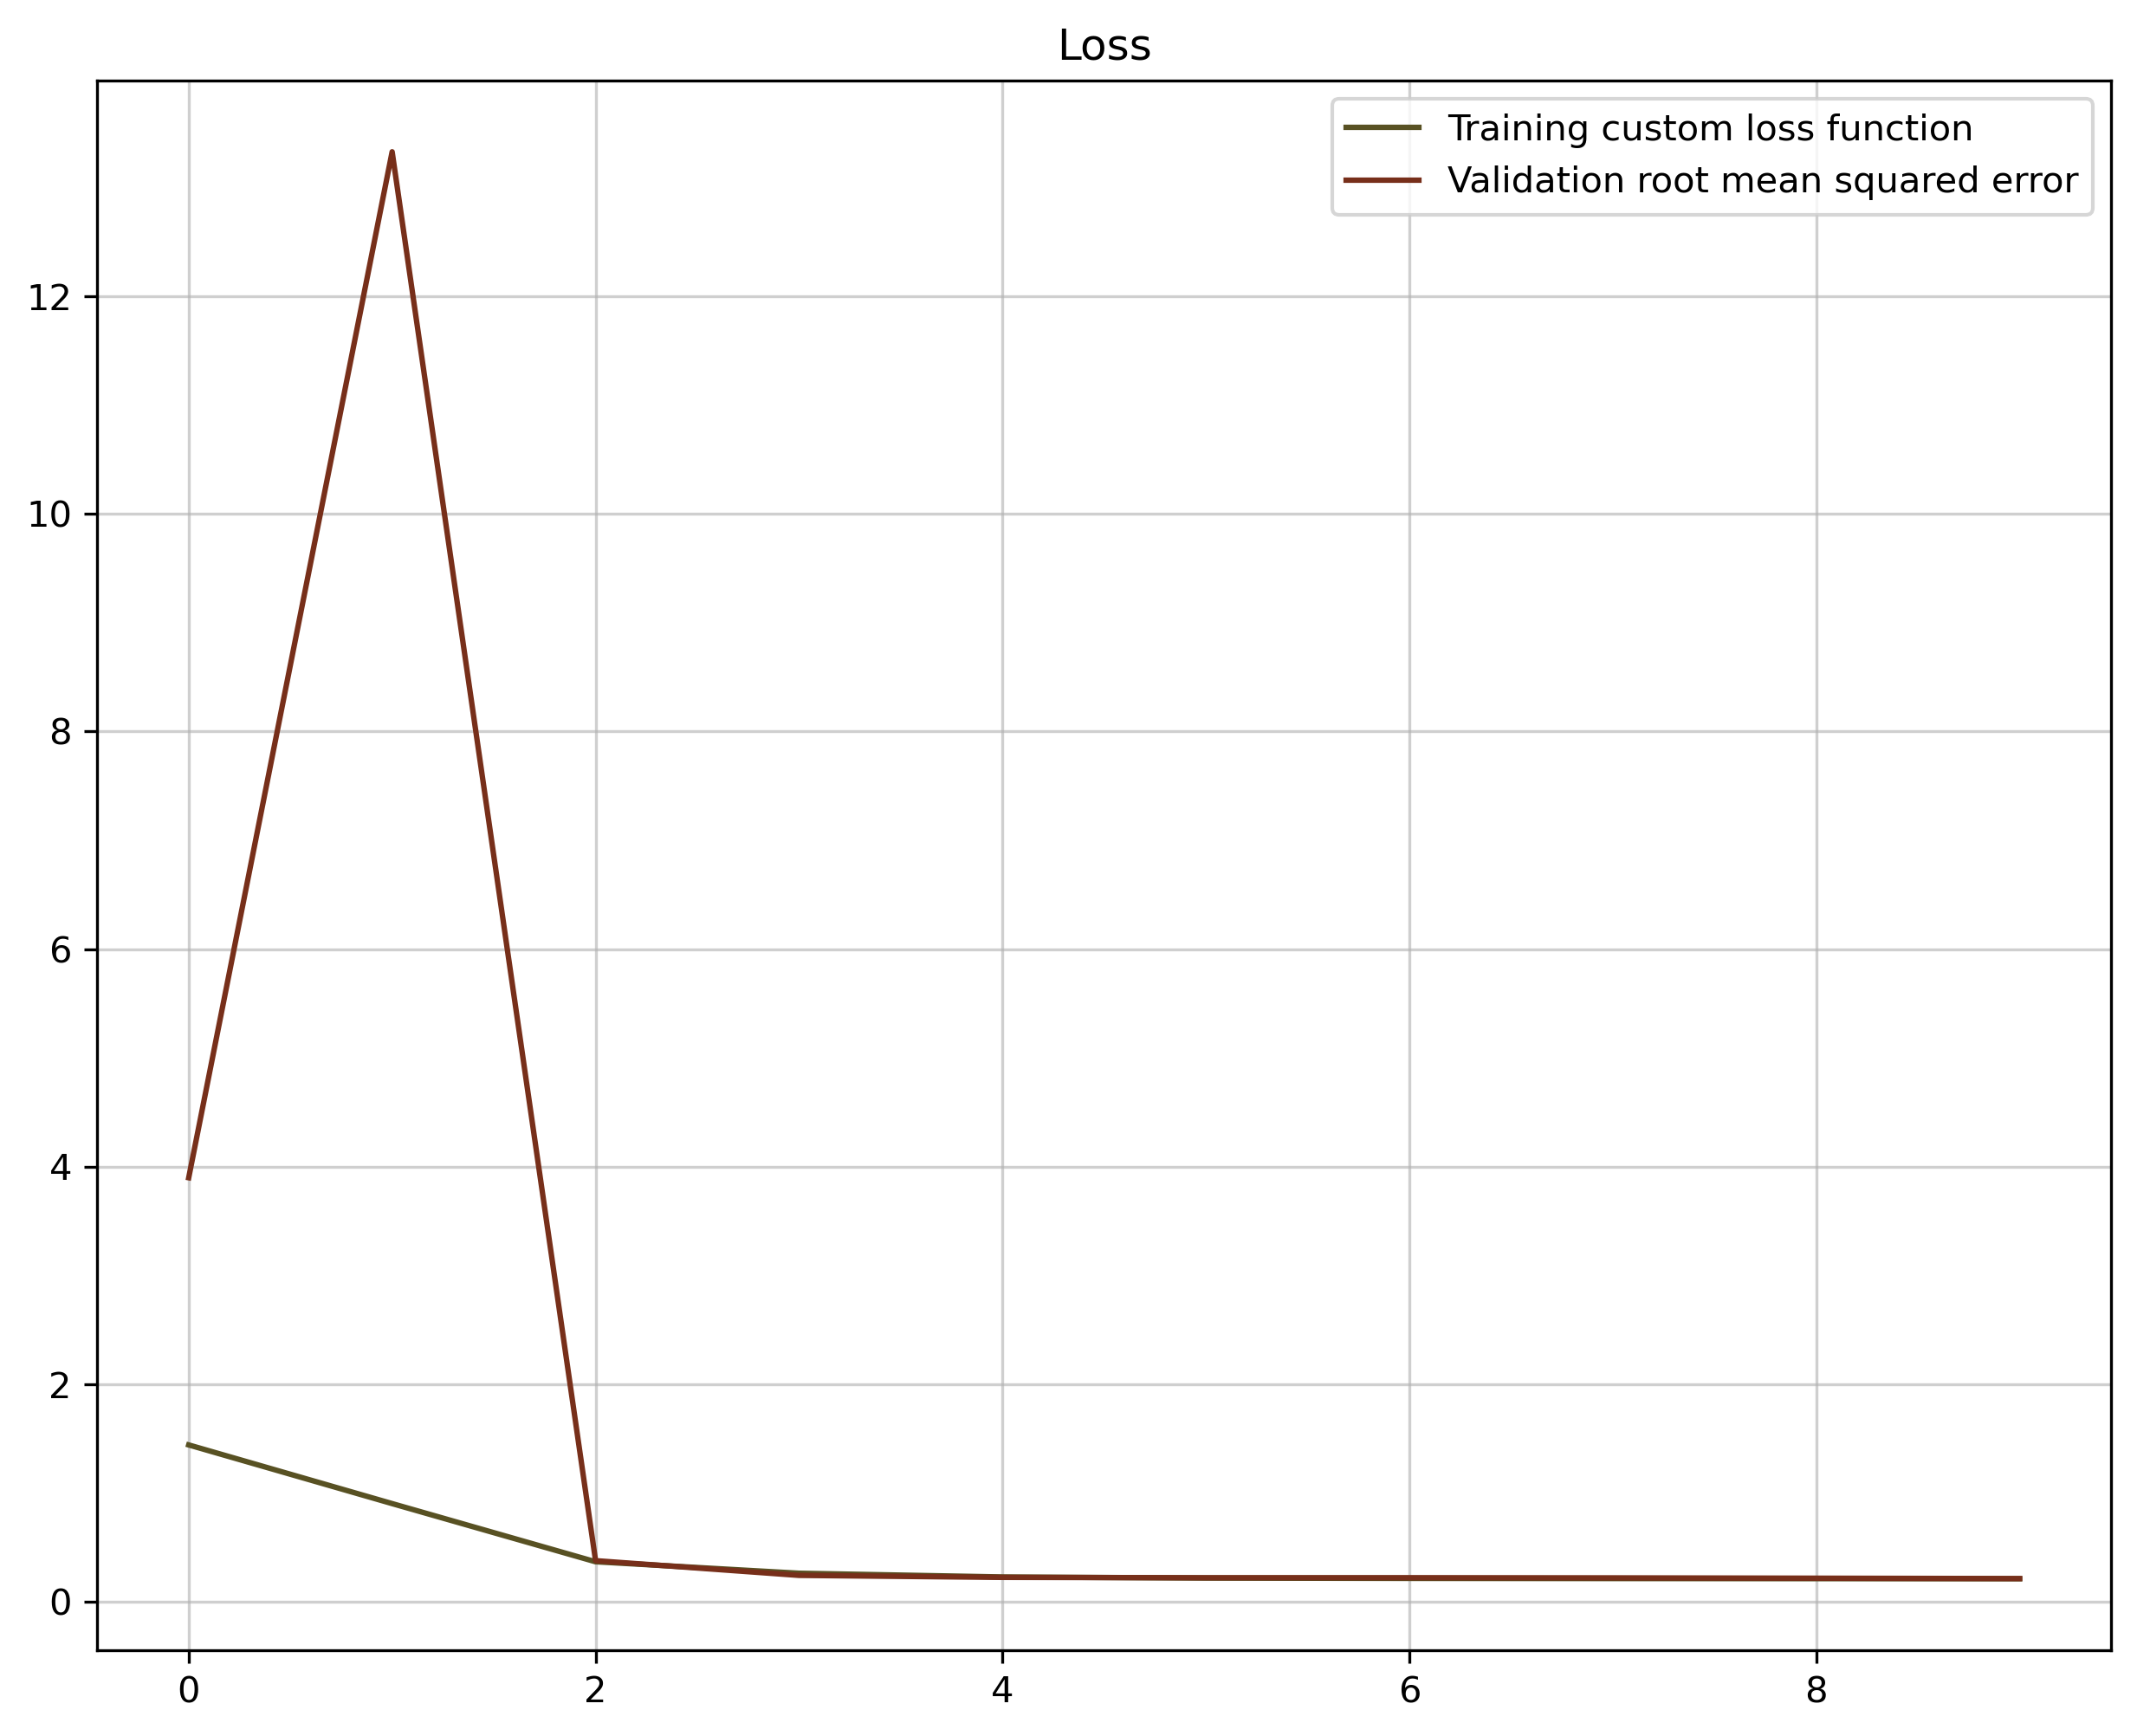

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=300)
plt.plot(train_loss_results, label="Training custom loss function",color="#585123")
plt.plot(train_accuracy_results, label="Validation root mean squared error",color="#772F1A")
plt.grid(alpha=0.6)
plt.title('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 198ms/step


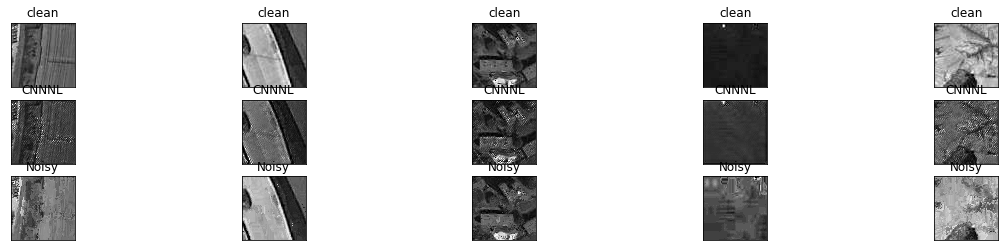

In [21]:
# Visualization
pros_ds_test = ds_test.map(tf_slicing2)
for batch_x, batch_y in pros_ds_test.batch(5).take(10):
    decoded_imgs = modelF5.predict(batch_x)
    
decoded_imgs= tf.clip_by_value(decoded_imgs, 0,1)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgs,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide

#The noisy image
trainD=tf.math.multiply(batch_x,np.log(256))
trainD=tf.math.add(tf.math.exp(trainD),-1)
trainD=trainD[:,:,:,1]

decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)
trainD= tf.clip_by_value(trainD, 0, 255)
import matplotlib.pyplot as plt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("clean")
    plt.imshow(tf.squeeze(test_y[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("CNNNL")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    cx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Noisy")
    plt.imshow(tf.squeeze(trainD[i]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)
plt.show()

# Cross validation 5

In [22]:
import tensorflow as tf
import os
import time
import numpy as np

def listaArchivos(path):
    """This function gets all the files in a directory"""
    filelist=[]
    with os.scandir(path) as entries:
        for i in entries:
            filelist.append(path+'/'+i.name)
    return filelist

def decode(serialized_example):
    featuress= tf.io.parse_single_example(
    serialized_example,
    features={'noisy': tf.io.FixedLenFeature(shape=(7225,), dtype= tf.float32),#85,85
      'clean':tf.io.FixedLenFeature(shape=(7225,), dtype=tf.float32),
      'NLM':tf.io.FixedLenFeature(shape=(81920,), dtype=tf.float32),#64,64,20
    })
    return featuress

# normal slicing

foldertrain = "./../DatasetBueno/cleanpart_0/train"# ./cleanpart_1/train
foldertest = "./../DatasetBueno/cleanpart_0/test"# ./cleanpart_1/test
#start = time.perf_counter()
#randomize the files
randtrainlist=np.array(listaArchivos(foldertrain))
np.random.shuffle(randtrainlist)
randtrainlist=list(randtrainlist)
randtestlist=np.array(listaArchivos(foldertest))
np.random.shuffle(randtestlist)
randtrainlist=list(randtestlist)
# data geneerator
ds_train = tf.data.TFRecordDataset(randtrainlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
ds_test = tf.data.TFRecordDataset(randtestlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
#print(time.perf_counter()-start)
# Disable the order so its faster to run
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
ds_train = ds_train.with_options(ignore_order)
ds_test = ds_test.with_options(ignore_order)# uses data as soon as it streams in, rather than in its original order
# try the simple function of slicing
#print(time.perf_counter()-start)# 31 segundos en cortar 12 gigas, aunque no las carga del todo. solo si las traigo a colación las carga
# Slicing normal didnt seemn to work well.

In [23]:
def sliceN2(data):
    data = tf.reshape(data, [85,85], name="noisy")
    data=tf.convert_to_tensor(data[11:75,11:75])
    data=tf.reshape(data,[64,64,1],name='noisy')
    return data
def sliceC(data):
    data = tf.reshape(data, [85,85], name="clean")
    data=tf.convert_to_tensor(data[11:75,11:75])
    return data
def sliceNLM(data):
    data = tf.reshape(data, [64,64,20], name="NLM")
    return data
#[image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#image.set_shape(im_shape)
def tf_slicing2(elem):
    clean=elem['clean']
    noisy=elem['noisy']
    NLM=elem['NLM']
    
    [clean,] = tf.py_function(sliceC,[clean], [tf.float32])#[clean,] =
    [noisy,] = tf.py_function(sliceN2,[noisy], [tf.float32])
    [NLM,] = tf.py_function(sliceNLM,[NLM], [tf.float32])
    noisy = tf.concat(axis=2, values=[noisy,NLM,])# concatenating the NLM with the noisy to get only one x
    noisy = tf.cast(noisy, tf.float64)# Converting to float64 to save longer values maybe
    clean = tf.cast(clean, tf.float64)# Converting to float64 to save longer values maybe
    #clip the bad data
    noisy = tf.clip_by_value(noisy, clip_value_min=0, clip_value_max=1, name='noisy')# Eliminate some weird infinities
    clean = tf.clip_by_value(clean, clip_value_min=0, clip_value_max=1, name='clean')# Eliminate some weird infinities
    
    
    return  noisy,clean

pros_ds_train = ds_train.map(tf_slicing2)
pros_ds_test = ds_test.map(tf_slicing2)

In [24]:
# custom loss function
import keras.backend as K
import sklearn

class CustomAccuracySAR2(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        #y_true=y_true[0]
        y_true,y_pred=tf.math.multiply(y_true,np.log(256)),tf.math.multiply(y_pred,np.log(256))# first denormalize
        y_true,y_pred=tf.math.add(tf.math.exp(y_true),-1),tf.math.add(tf.math.exp(y_pred),-1)# then add subtract the slide
        # Clipping
        y_true= tf.clip_by_value(y_true, 0, 255)
        y_pred= tf.clip_by_value(y_pred, 0, 255)
        denom = tf.math.sqrt(tf.math.multiply(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01)))# the 0.02 is to avoid the problem with the logarithm
        SARdist= tf.math.log(tf.math.divide(tf.math.add(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01))+0.001,denom + 0.001))
        return SARdist
    
def custom_loss(y_true, y_pred):
    l_1 = 0.7
    l_2 = 0.3
    mse = tf.keras.losses.MeanSquaredError()
    SARdist = CustomAccuracySAR2()
    loss_Sard = SARdist(y_true , y_pred)
    loss_mse = mse(y_true , y_pred)
    total_loss = l_1*loss_mse + l_2*loss_Sard.numpy()
    return total_loss

In [25]:
### This one worksss
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import time

#Memory configuration
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.inter_op_parallelism_threads = 8
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session((tf.compat.v1.Session(config=config)))


# general parameters and 
Epochs = 10
batch_size=128
AUTOTUNE = tf.data.AUTOTUNE
pros_ds_train = pros_ds_train.batch(batch_size = batch_size , drop_remainder=True)
pros_ds_test = pros_ds_test.batch(batch_size = batch_size , drop_remainder=True)
pros_ds_train = pros_ds_train.prefetch(buffer_size=AUTOTUNE)
pros_ds_test = pros_ds_test.prefetch(buffer_size=AUTOTUNE)


modelF = keras.Model(inputs=inputs, outputs=outputs)
#modelF2.summary()
modelF.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), loss=custom_loss, metrics=[tf.keras.metrics.MeanSquaredError()], run_eagerly=True)

First_time = time.time()
callbacks = [
    keras.callbacks.EarlyStopping(# This is for early stopping and convergence
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-1,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
train_loss_results = []
train_accuracy_results = []
iterator = iter(pros_ds_train)
iter2 = iter(pros_ds_test)
# If this doesn't worlk make epochs more and erase the for epochs
for j in range(Epochs):
    history = modelF.fit(iterator,
                    epochs=1,
                    callbacks=callbacks,
                    validation_data=iter2,#pros_ds_test
                    batch_size=batch_size)#batch_size=batch_size)#batch_size=batch_size
    iterator = iter(pros_ds_train)
    iter2 = iter(pros_ds_test)
    print(j)
    modelF.save('CNNLM5Iter')
    train_loss_results.append(history.history["loss"])
    train_accuracy_results.append(history.history["val_loss"])
print("Total tim: %.2fs" % (time.time() - First_time))
#new_model = keras.models.load_model('path_to_my_model.h5')

283/283 [==============================] - 5005s 18s/step - loss: 0.2162 - mean_squared_error: 0.0048 - val_loss: 0.2111 - val_mean_squared_error: 0.0014
0


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


283/283 [==============================] - 4995s 18s/step - loss: 0.2109 - mean_squared_error: 0.0013 - val_loss: 0.2105 - val_mean_squared_error: 0.0011
1


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


283/283 [==============================] - 5015s 18s/step - loss: 0.2102 - mean_squared_error: 8.6985e-04 - val_loss: 0.2090 - val_mean_squared_error: 4.5872e-04
2


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


283/283 [==============================] - 4988s 18s/step - loss: 0.2096 - mean_squared_error: 6.1001e-04 - val_loss: 0.2087 - val_mean_squared_error: 3.0207e-04
3


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


283/283 [==============================] - 5006s 18s/step - loss: 0.2093 - mean_squared_error: 4.0728e-04 - val_loss: 0.2096 - val_mean_squared_error: 7.2991e-04
4


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


283/283 [==============================] - 5010s 18s/step - loss: 0.2091 - mean_squared_error: 3.1902e-04 - val_loss: 0.2082 - val_mean_squared_error: 1.4490e-04
5


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


283/283 [==============================] - 5961s 21s/step - loss: 0.2090 - mean_squared_error: 2.4414e-04 - val_loss: 0.2084 - val_mean_squared_error: 2.7635e-04
6


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


283/283 [==============================] - 8185s 29s/step - loss: 0.2089 - mean_squared_error: 1.9430e-04 - val_loss: 0.2083 - val_mean_squared_error: 2.1340e-04
7


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


283/283 [==============================] - 8190s 29s/step - loss: 0.2089 - mean_squared_error: 1.7500e-04 - val_loss: 0.2083 - val_mean_squared_error: 2.0547e-04
8


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


283/283 [==============================] - 8218s 29s/step - loss: 0.2088 - mean_squared_error: 1.6290e-04 - val_loss: 0.2083 - val_mean_squared_error: 1.6892e-04
9


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


INFO:tensorflow:Assets written to: CNNLM5Iter\assets


Total tim: 60631.86s


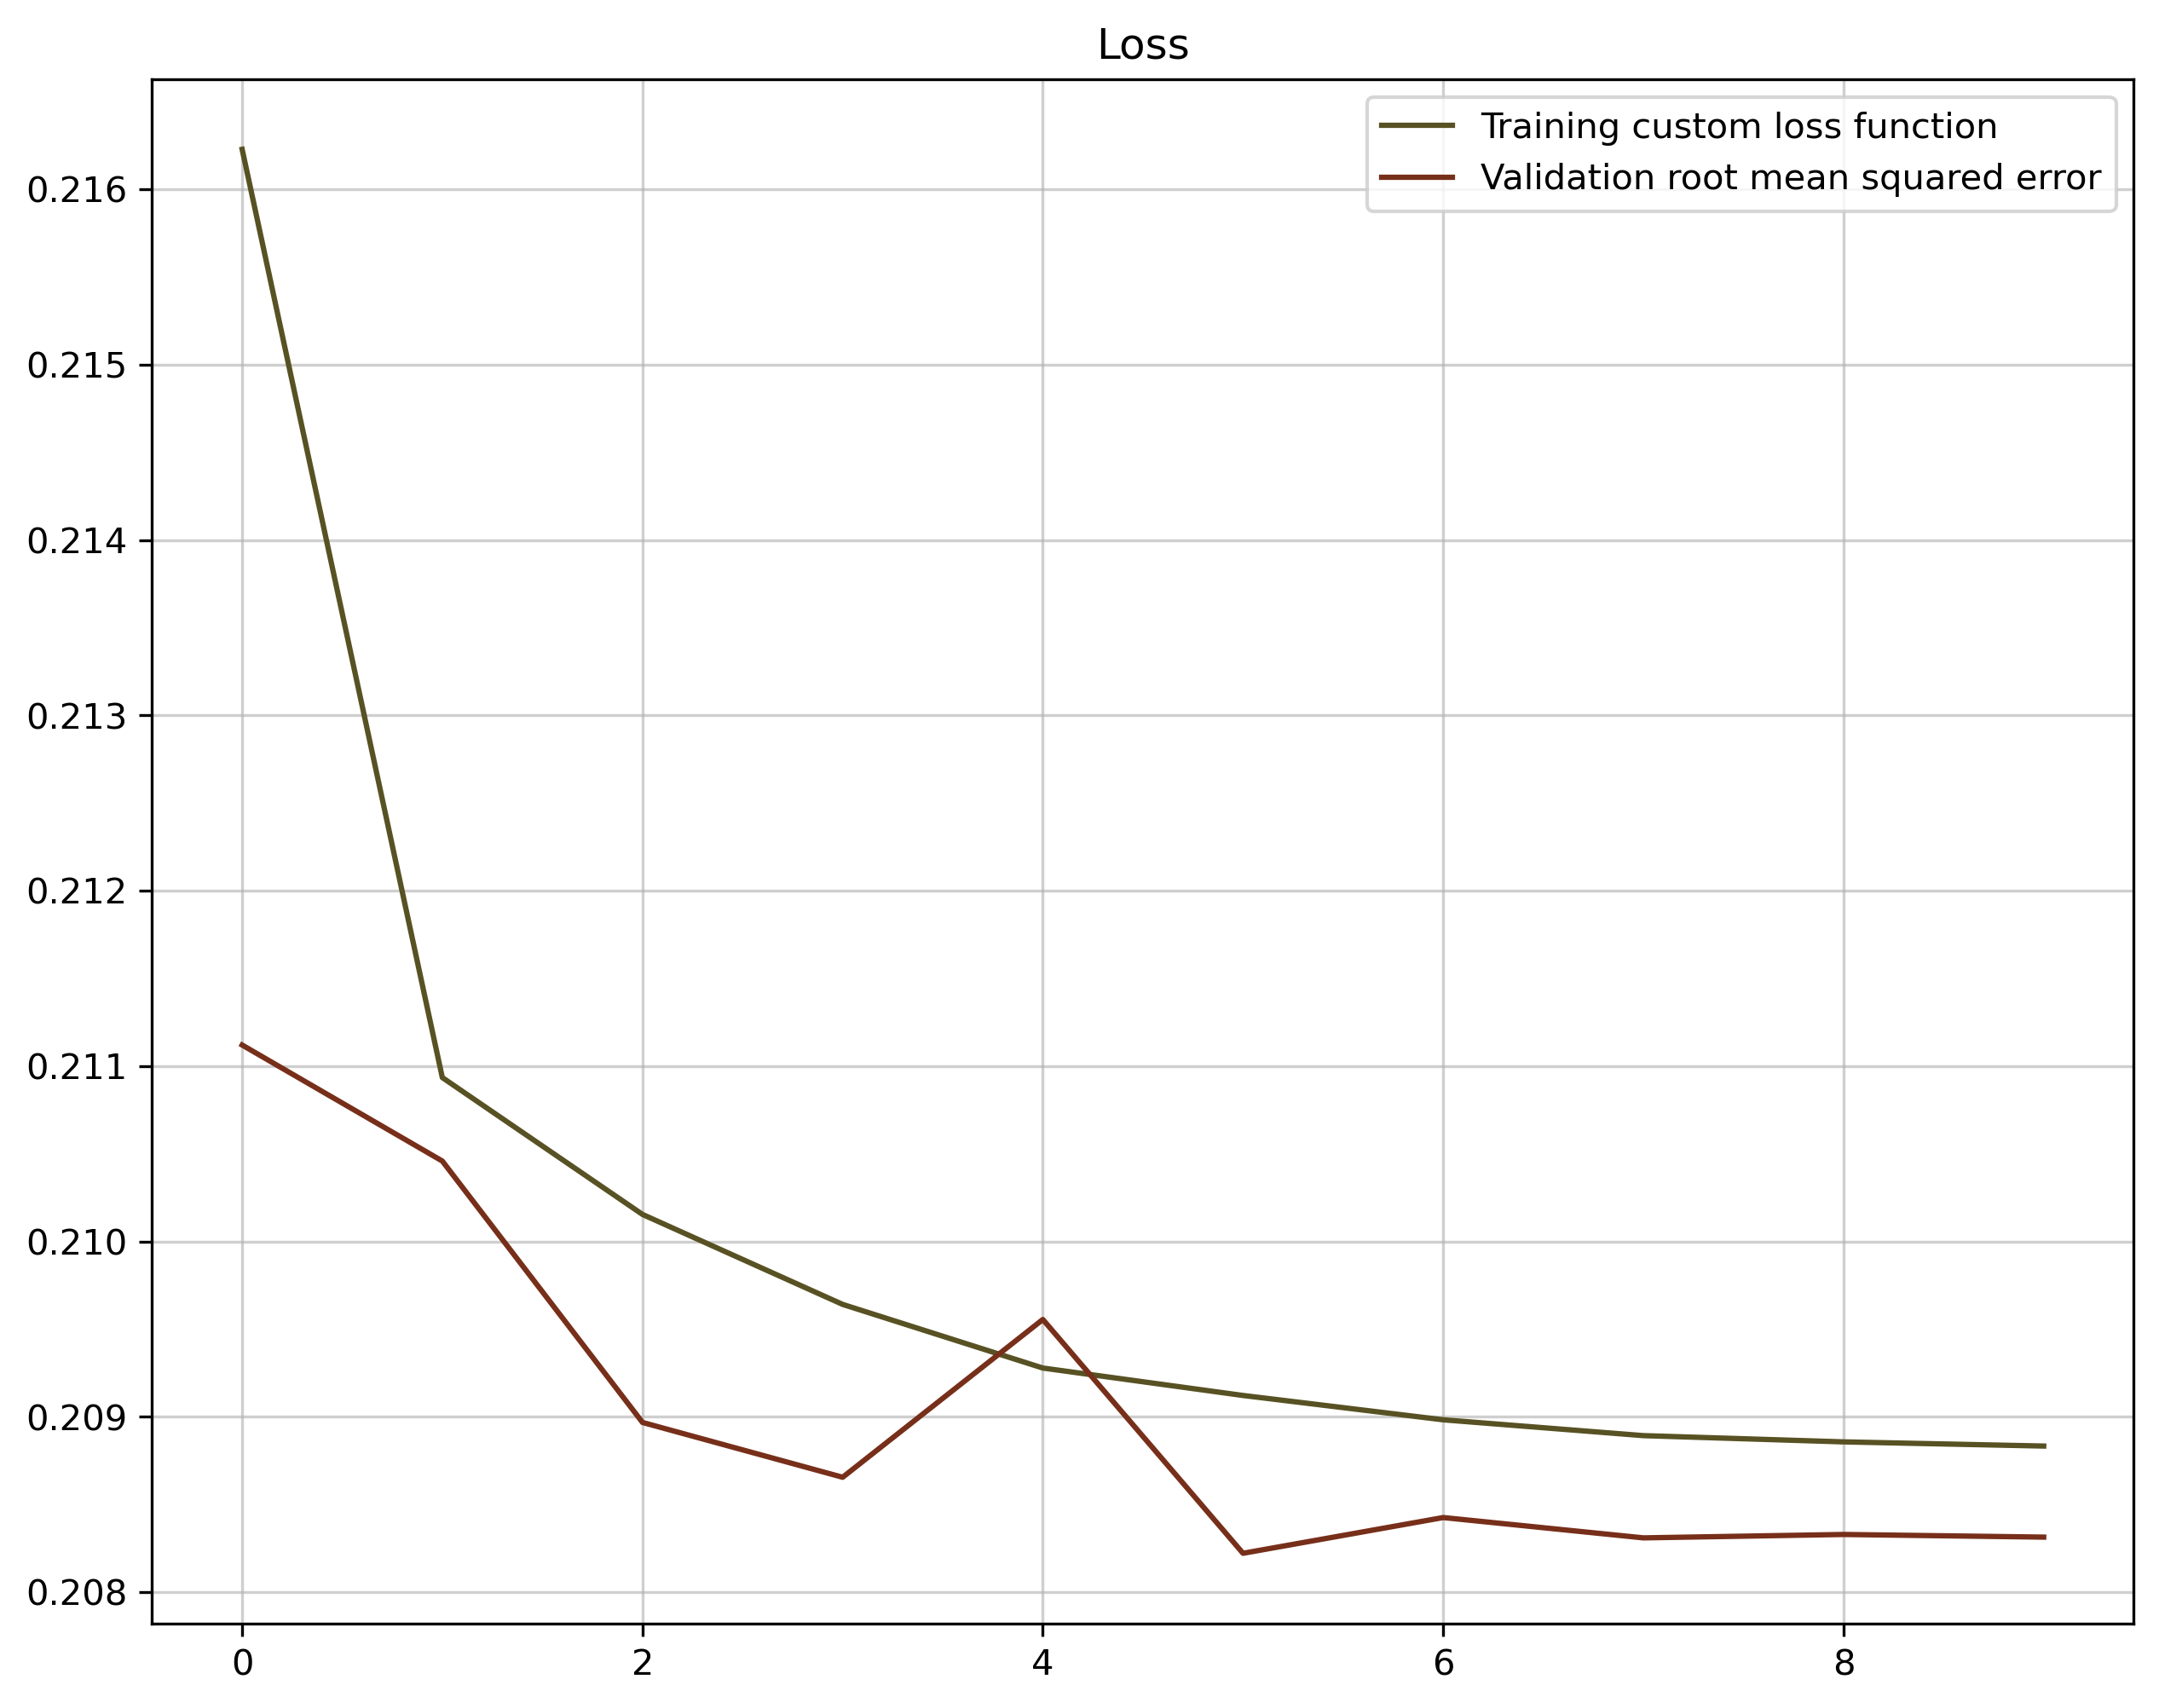

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=300)
plt.plot(train_loss_results, label="Training custom loss function",color="#585123")
plt.plot(train_accuracy_results, label="Validation root mean squared error",color="#772F1A")
plt.grid(alpha=0.6)
plt.title('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 317ms/step


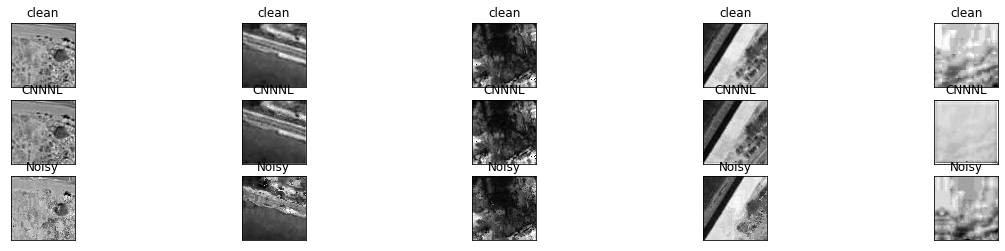

In [27]:
# Visualization
pros_ds_test = ds_test.map(tf_slicing2)
for batch_x, batch_y in pros_ds_test.batch(5).take(10):
    decoded_imgs = modelF.predict(batch_x)
    
decoded_imgs= tf.clip_by_value(decoded_imgs, 0,1)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgs,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide

#The noisy image
trainD=tf.math.multiply(batch_x,np.log(256))
trainD=tf.math.add(tf.math.exp(trainD),-1)
trainD=trainD[:,:,:,1]

decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)
trainD= tf.clip_by_value(trainD, 0, 255)
import matplotlib.pyplot as plt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("clean")
    plt.imshow(tf.squeeze(test_y[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("CNNNL")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    cx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Noisy")
    plt.imshow(tf.squeeze(trainD[i]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)
plt.show()

# Validation

In [34]:
import tensorflow as tf
import os
import time
import numpy as np

def listaArchivos(path):
    """This function gets all the files in a directory"""
    filelist=[]
    with os.scandir(path) as entries:
        for i in entries:
            filelist.append(path+'/'+i.name)
    return filelist

def decode(serialized_example):
    featuress= tf.io.parse_single_example(
    serialized_example,
    features={'noisy': tf.io.FixedLenFeature(shape=(7225,), dtype= tf.float32),#85,85
      'clean':tf.io.FixedLenFeature(shape=(7225,), dtype=tf.float32),
      'NLM':tf.io.FixedLenFeature(shape=(81920,), dtype=tf.float32),#64,64,20
    })
    return featuress

# normal slicing


foldertest = "./../DatasetBueno/validation"# ./cleanpart_1/test
#start = time.perf_counter()
#randomize the files
randtestlist=np.array(listaArchivos(foldertest))
np.random.shuffle(randtestlist)
randtrainlist=list(randtestlist)
# data geneerator
ds_val = tf.data.TFRecordDataset(randtestlist,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
#print(time.perf_counter()-start)
# Disable the order so its faster to run
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
ds_val =  ds_val.with_options(ignore_order)# uses data as soon as it streams in, rather than in its original order
# try the simple function of slicing
#print(time.perf_counter()-start)# 31 segundos en cortar 12 gigas, aunque no las carga del todo. solo si las traigo a colación las carga
# Slicing normal didnt seemn to work well.

In [36]:
def sliceN2(data):
    data = tf.reshape(data, [85,85], name="noisy")
    data=tf.convert_to_tensor(data[11:75,11:75])
    data=tf.reshape(data,[64,64,1],name='noisy')
    return data
def sliceC(data):
    data = tf.reshape(data, [85,85], name="clean")
    data=tf.convert_to_tensor(data[11:75,11:75])
    return data
def sliceNLM(data):
    data = tf.reshape(data, [64,64,20], name="NLM")
    return data
#[image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#image.set_shape(im_shape)
def tf_slicing2(elem):
    clean=elem['clean']
    noisy=elem['noisy']
    NLM=elem['NLM']
    
    [clean,] = tf.py_function(sliceC,[clean], [tf.float32])#[clean,] =
    [noisy,] = tf.py_function(sliceN2,[noisy], [tf.float32])
    [NLM,] = tf.py_function(sliceNLM,[NLM], [tf.float32])
    noisy = tf.concat(axis=2, values=[noisy,NLM,])# concatenating the NLM with the noisy to get only one x
    noisy = tf.cast(noisy, tf.float64)# Converting to float64 to save longer values maybe
    clean = tf.cast(clean, tf.float64)# Converting to float64 to save longer values maybe
    #clip the bad data
    noisy = tf.clip_by_value(noisy, clip_value_min=0, clip_value_max=1, name='noisy')# Eliminate some weird infinities
    clean = tf.clip_by_value(clean, clip_value_min=0, clip_value_max=1, name='clean')# Eliminate some weird infinities
    
    
    return  noisy,clean

ds_val = ds_val.map(tf_slicing2)
# custom loss function
import keras.backend as K
import sklearn

class CustomAccuracySAR2(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        #y_true=y_true[0]
        y_true,y_pred=tf.math.multiply(y_true,np.log(256)),tf.math.multiply(y_pred,np.log(256))# first denormalize
        y_true,y_pred=tf.math.add(tf.math.exp(y_true),-1),tf.math.add(tf.math.exp(y_pred),-1)# then add subtract the slide
        # Clipping
        y_true= tf.clip_by_value(y_true, 0, 255)
        y_pred= tf.clip_by_value(y_pred, 0, 255)
        denom = tf.math.sqrt(tf.math.multiply(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01)))# the 0.02 is to avoid the problem with the logarithm
        SARdist= tf.math.log(tf.math.divide(tf.math.add(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01))+0.001,denom + 0.001))
        return SARdist
    
def custom_loss(y_true, y_pred):
    l_1 = 0.7
    l_2 = 0.3
    mse = tf.keras.losses.MeanSquaredError()
    SARdist = CustomAccuracySAR2()
    loss_Sard = SARdist(y_true , y_pred)
    loss_mse = mse(y_true , y_pred)
    total_loss = l_1*loss_mse + l_2*loss_Sard.numpy()
    return total_loss

TypeError: in user code:


    TypeError: tf__tf_slicing2() takes 1 positional argument but 2 were given


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import time

#Memory configuration
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.inter_op_parallelism_threads = 8
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session((tf.compat.v1.Session(config=config)))

batch_size=128
AUTOTUNE = tf.data.AUTOTUNE
ds_val = ds_val.batch(batch_size = batch_size , drop_remainder=True)
ds_val = ds_val.prefetch(buffer_size=AUTOTUNE)

train_loss_results = []
train_accuracy_results = []
iterator = iter(ds_val)
# If this doesn't worlk make epochs more and erase the for epochs

history = modelF.evaluate(iterator,
                callbacks=callbacks,#pros_ds_test
                batch_size=batch_size)#batch_size=batch_size)#batch_size=batch_size
print("The validation loss is: ",history[0],"The validation MSE metric is: ",history[1])
print("Total tim: %.2fs" % (time.time() - First_time))

In [32]:
print("The validation loss is: ",history[0],"The validation MSE metric is: ",history[1])

The validation loss is:  0.20831942558288574 The validation MSE metric is:  0.0001714014942990616


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=300)
plt.plot(train_loss_results, label="Training custom loss function",color="#585123")
plt.plot(train_accuracy_results, label="Validation root mean squared error",color="#772F1A")
plt.grid(alpha=0.6)
plt.title('Loss')
plt.legend()
plt.show()
